In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import argparse
import numpy as np
import numpy.typing as npt
import pandas as pd
import yaml

from pathlib import Path
from tqdm import tqdm
from tensorflow import data
from tensorflow.keras.models import load_model

from utils import IsValidFile, IsReadableDir, CreateFolder, predict_single_image
from generator import RegionETGenerator

import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use('CMS')

from typing import List

import json

In [2]:
#plt.rcParams["font.size"] = 18
#plt.rcParams["xaxis.labellocation"] = "right"
#plt.rcParams["yaxis.labellocation"] = "top"
# print(plt.rcParams.keys())
# plt.rcParams["xlabel.loc"] = 'right'

In [3]:
def loss(y_true: npt.NDArray, y_pred: npt.NDArray) -> npt.NDArray:
    return np.mean((y_true - y_pred) ** 2, axis=(1, 2, 3))

def quantize(arr: npt.NDArray, precision: tuple = (16, 8)) -> npt.NDArray:
    word, int_ = precision
    decimal = word - int_
    step = 1 / 2**decimal
    max_ = 2**int_ - step
    arrq = step * np.round(arr / step)
    arrc = np.clip(arrq, 0, max_)
    return arrc


def get_deposits(datasets):
    generator = RegionETGenerator()
    deposits, labels = [], []
    for dataset in datasets:
        name = dataset["name"]
        X = generator.get_data(dataset["path"])
        print(f"{name} samples: {X.shape[0]}")
        deposits.append(X)
        labels.append(name)
    return deposits, labels

In [4]:
INTERACTIVE = True
OUT_DIR = 'plots/dp-note'

def save_fig(name: str):
    plt.savefig(
        f"{OUT_DIR}/{name}.png", bbox_inches="tight"
    )
    if INTERACTIVE:
        plt.show()
    plt.close()

In [5]:
# setup data loaders & load models
config = yaml.safe_load(open('misc/config-macbook-npv.yml'))
# config = yaml.safe_load(open('misc/config-macbook-good-runs-only.yml'))

datasets = [i["path"] for i in config["background"] if i["use"]]
datasets = [path for paths in datasets for path in paths]

gen = RegionETGenerator()
X_train, X_val, X_test = gen.get_data_split(datasets)
X_signal, _, nPV_signal = gen.get_benchmark(config["signal"], filter_acceptance=False)
gen_train = gen.get_generator(X_train, X_train, 512, True)
gen_val = gen.get_generator(X_val, X_val, 512)
outlier_train = gen.get_data(config["exposure"]["training"])
outlier_val = gen.get_data(config["exposure"]["validation"])

X_train_student = np.concatenate([X_train, outlier_train])
X_val_student = np.concatenate([X_val, outlier_train])

X_good_pu = gen.get_data(config["background-good-pu"][0]["path"])

teacher = load_model("models/from-eos/teacher")
cicada_v1 = load_model("models/from-eos/cicada-v1")
cicada_v2 = load_model("models/from-eos/cicada-v2")

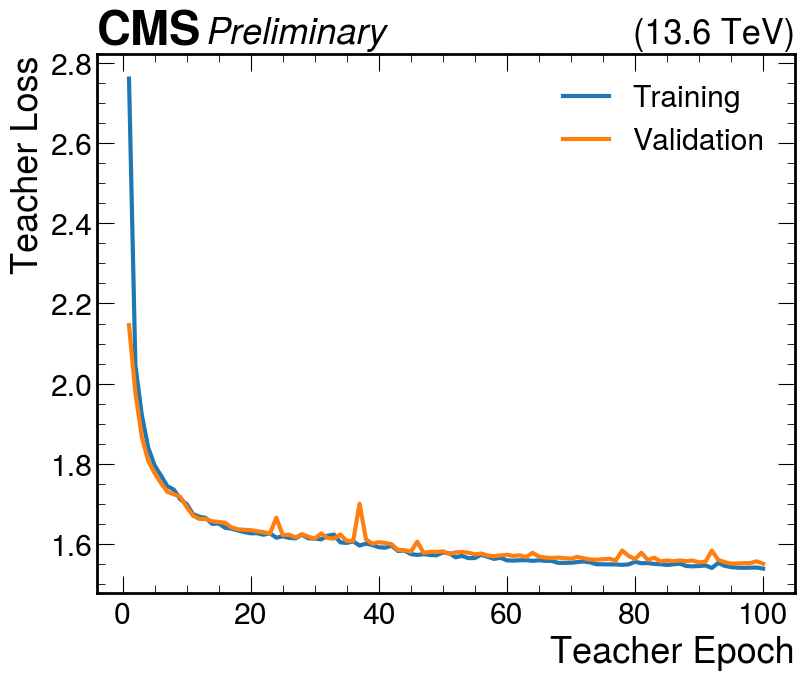

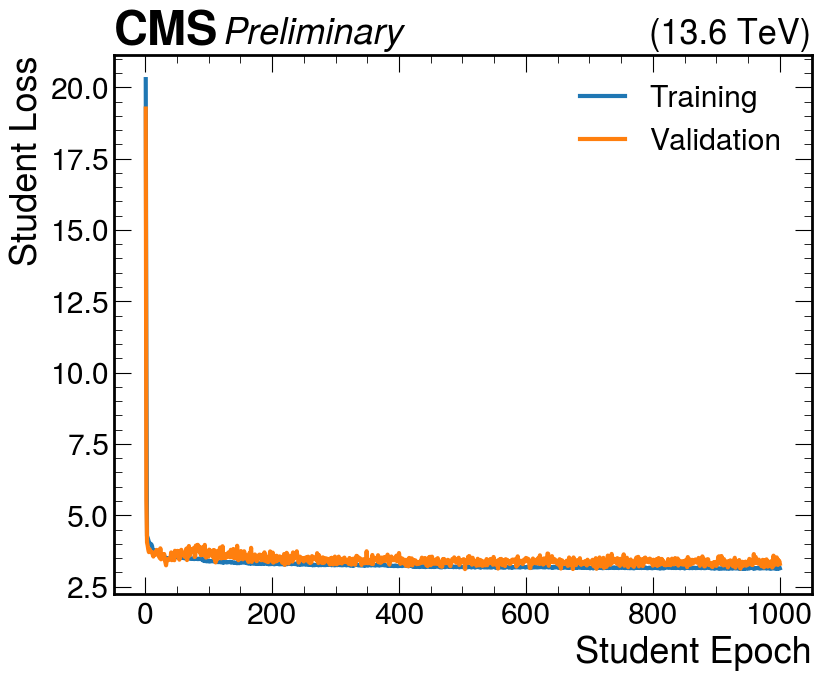

In [ ]:
# Loss curves
def plot_loss_history(
    training_loss: npt.NDArray, validation_loss: npt.NDArray, name: str, xlabel="Epoch", ylabel="Loss"
):
    plt.figure(figsize=(9, 7))
    plt.plot(np.arange(1, len(training_loss) + 1), training_loss, label="Training", linewidth=3)
    plt.plot(
        np.arange(1, len(validation_loss) + 1), validation_loss, label="Validation", linewidth=3
    )
    plt.legend(loc="upper right")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # ylim = plt.gca().get_ylim()
    # plt.gca().set_ylim(ylim[0], 0.5*ylim[1])
    # # plt.yscale("log")
    
    # axl = hep.cms.label('Preliminary', data=True, com=13.6, loc=1, fontsize=18)

    axl = hep.cms.text('Preliminary', loc=0)
    hep.cms.lumitext(r'(13.6 TeV)')

    # axl[0].set_x(0.1)
    # axl[1].set_x(0.1)
    save_fig(name)

log = pd.read_csv("models/from-eos/teacher/training.log")
plot_loss_history(
    log["loss"][4:104], log["val_loss"][4:104], "training-history-teacher", xlabel="Teacher Epoch", ylabel="Teacher Loss"
)

log = pd.read_csv("models/from-eos/cicada-v2/training.log")
plot_loss_history(
    log["loss"][40:1040], log["val_loss"][40:1040], "training-history-cicada-v2", xlabel="Student Epoch", ylabel="Student Loss"
)

2023 ZB Run B samples: 179988
2023 ZB Run C samples: 174997
2023 ZB Run D samples: 174420
2023 EZB Run C samples: 301669


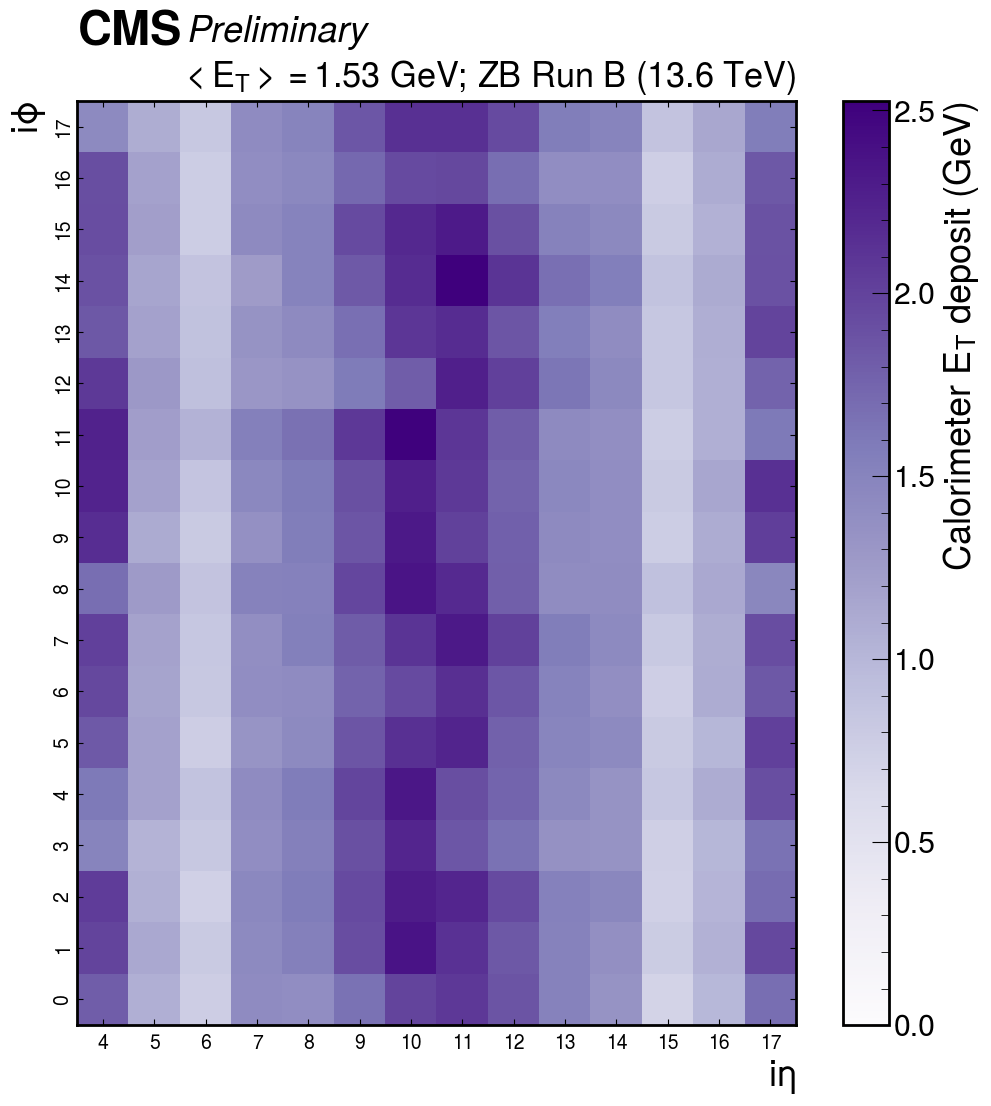

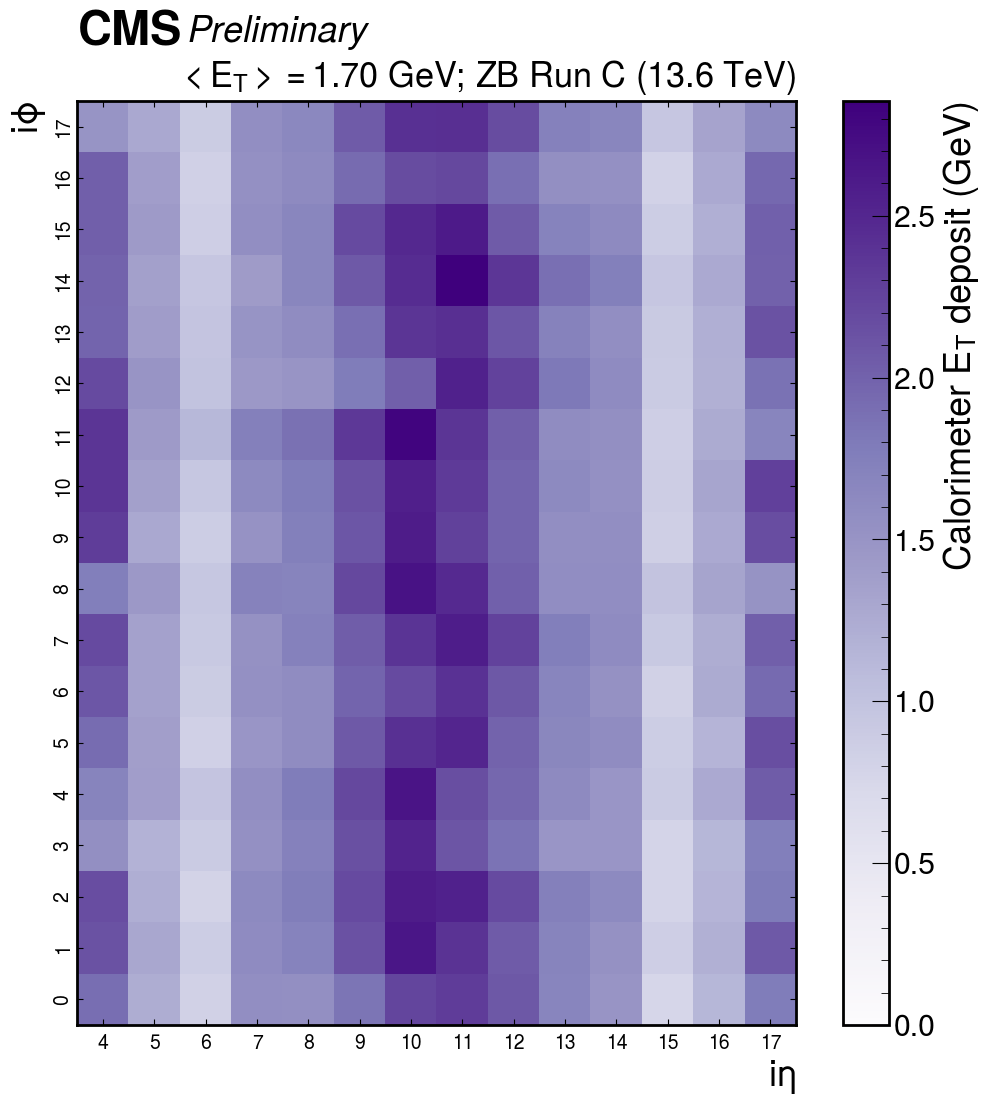

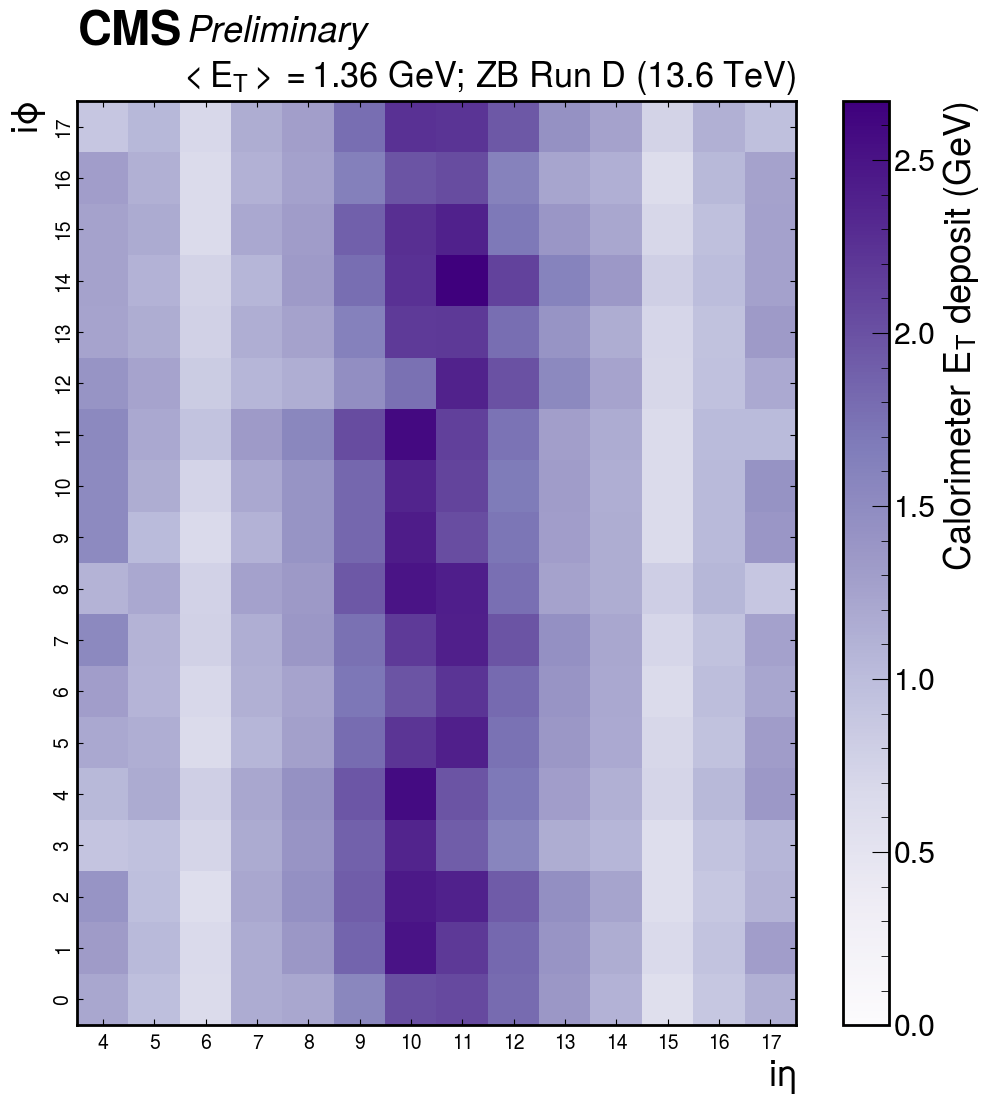

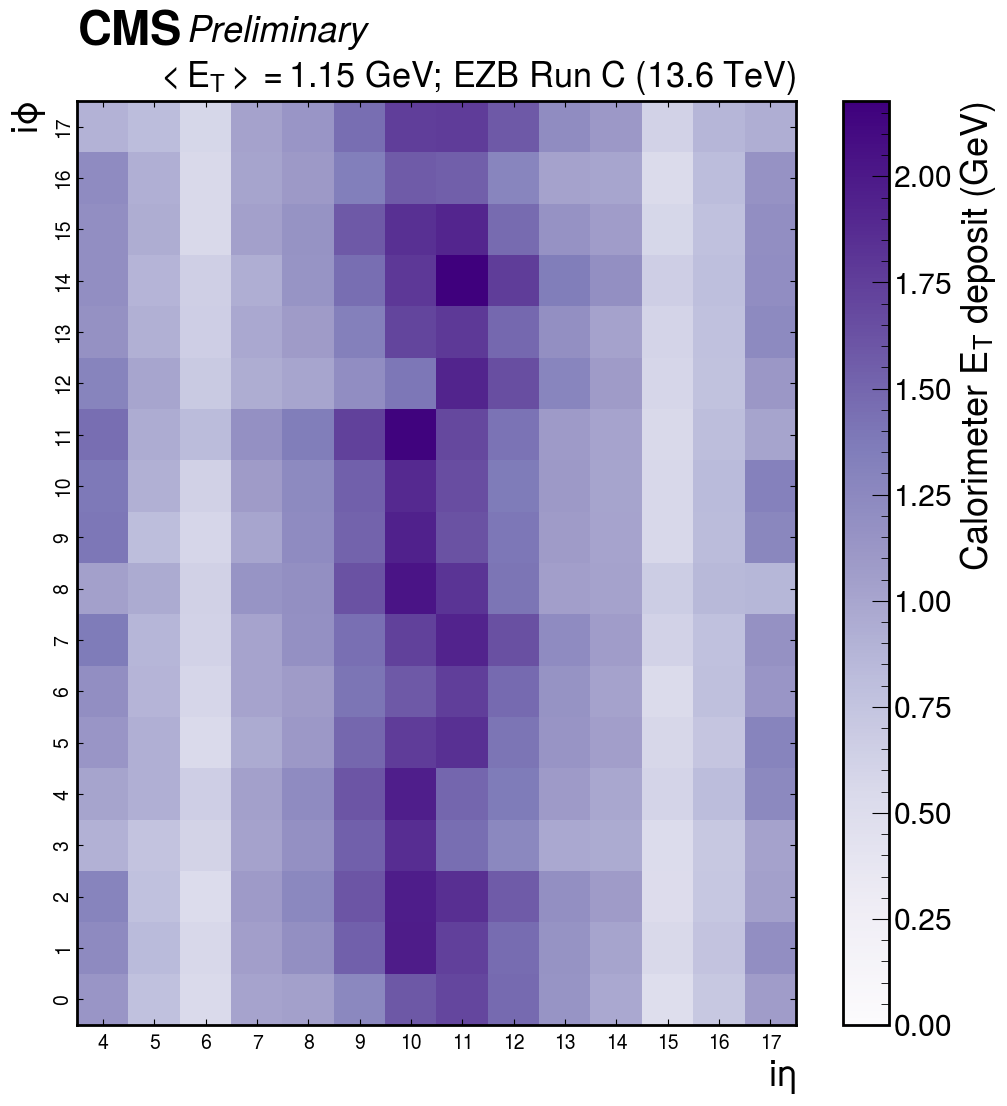

SUEP samples: 100000
HtoLongLived samples: 40000
VBFHto2C samples: 98985
TT samples: 100067
SUSYGGBBH samples: 98899


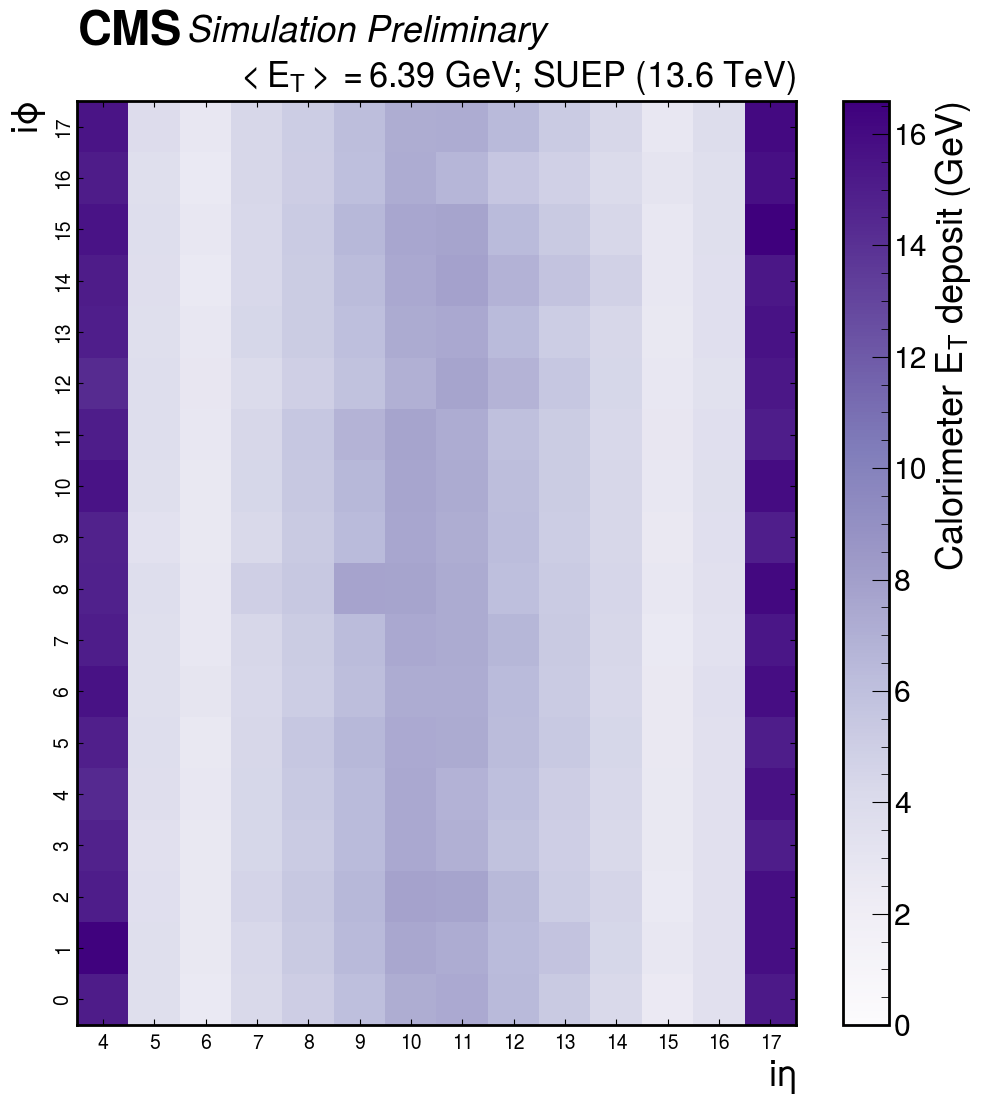

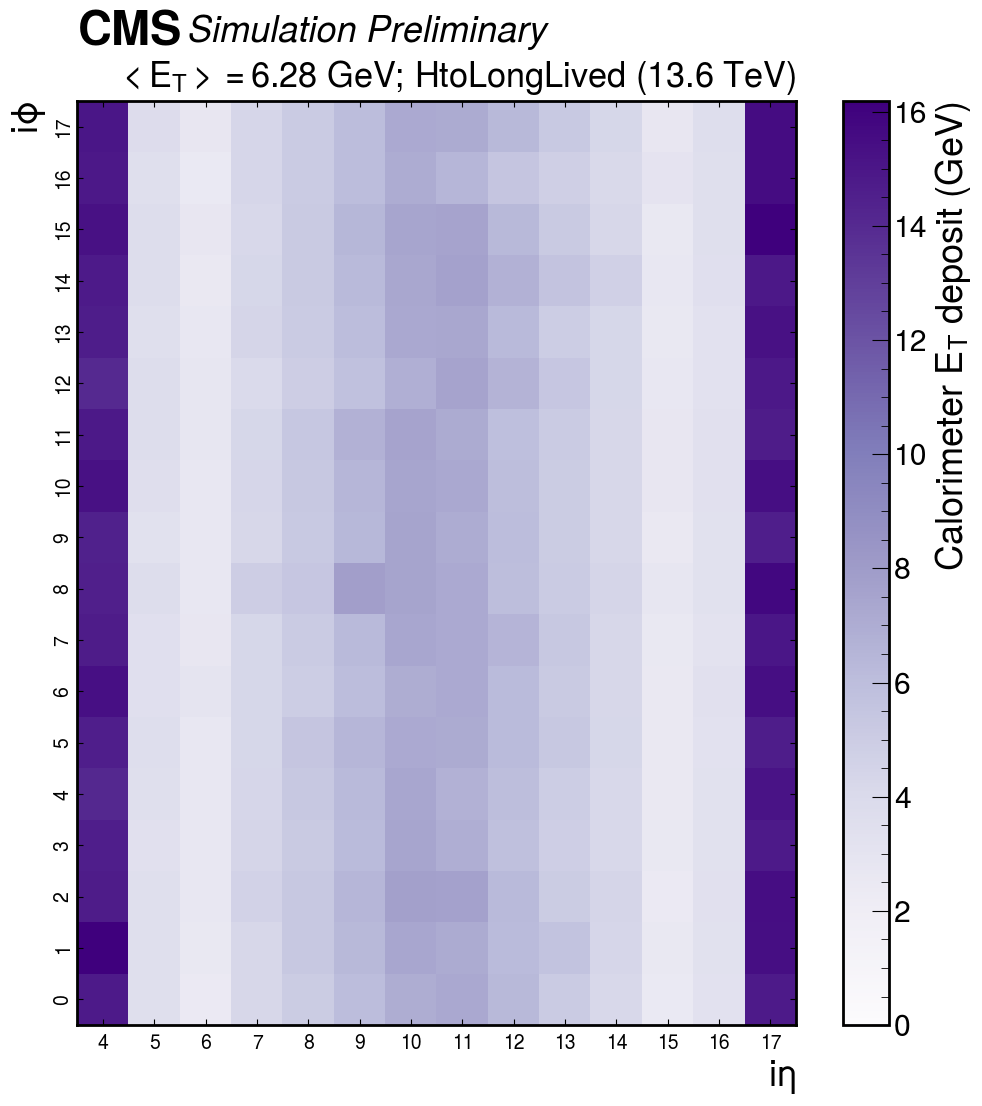

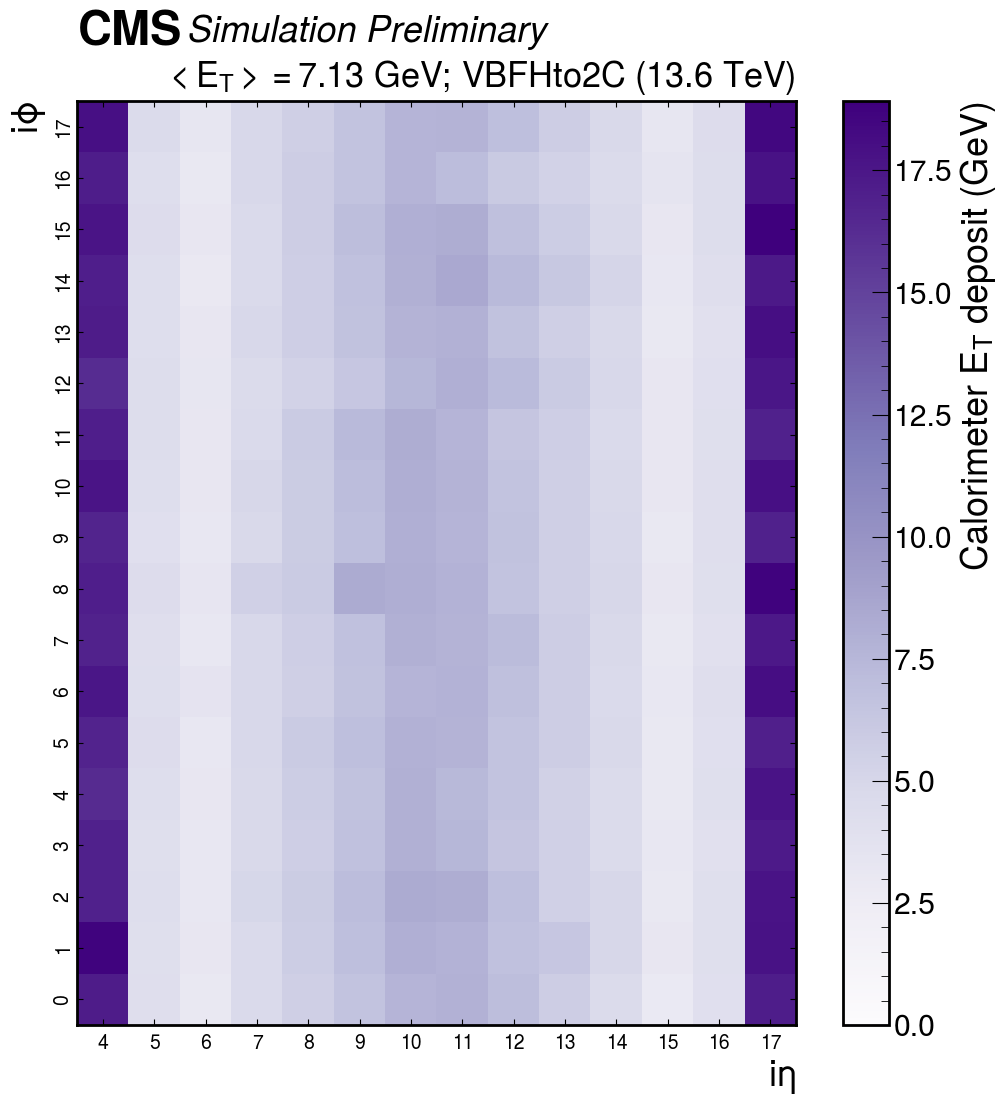

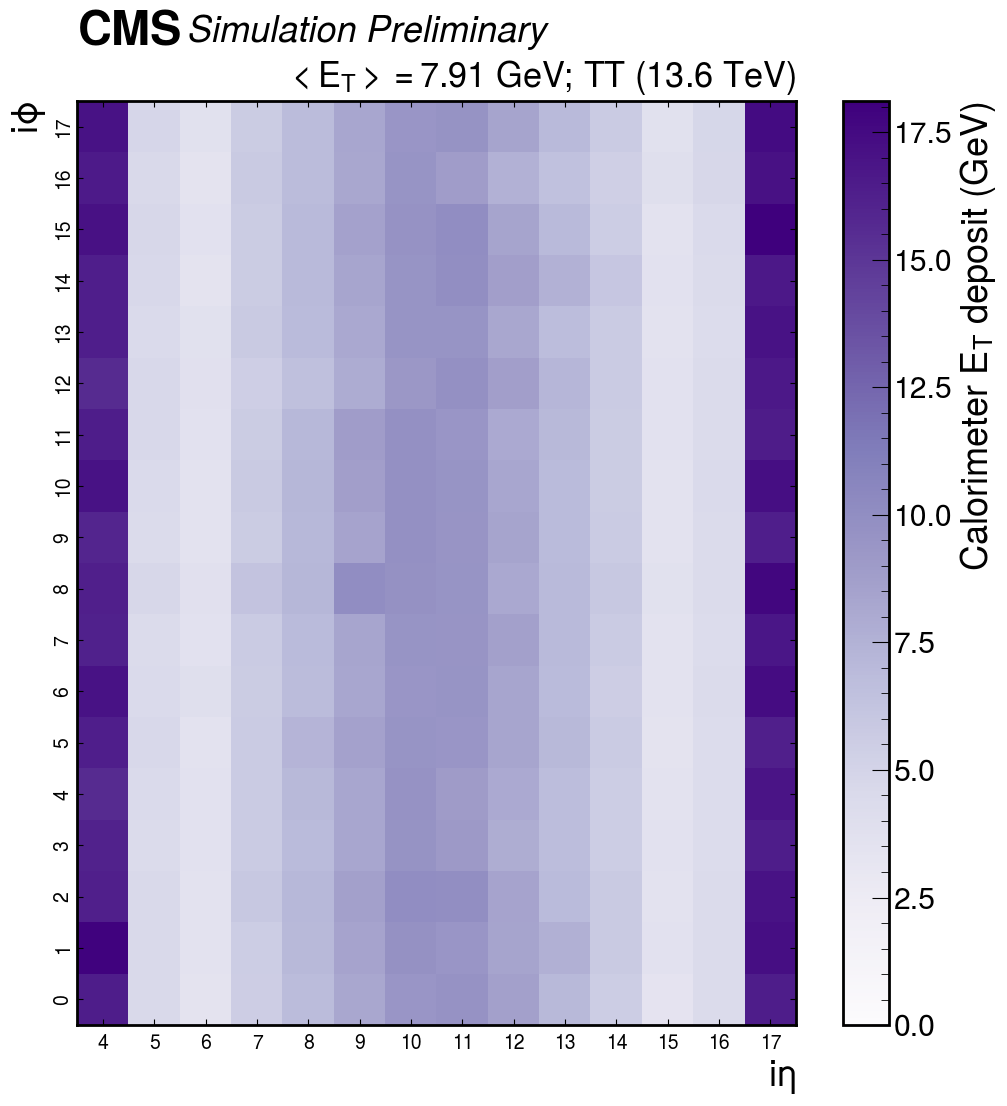

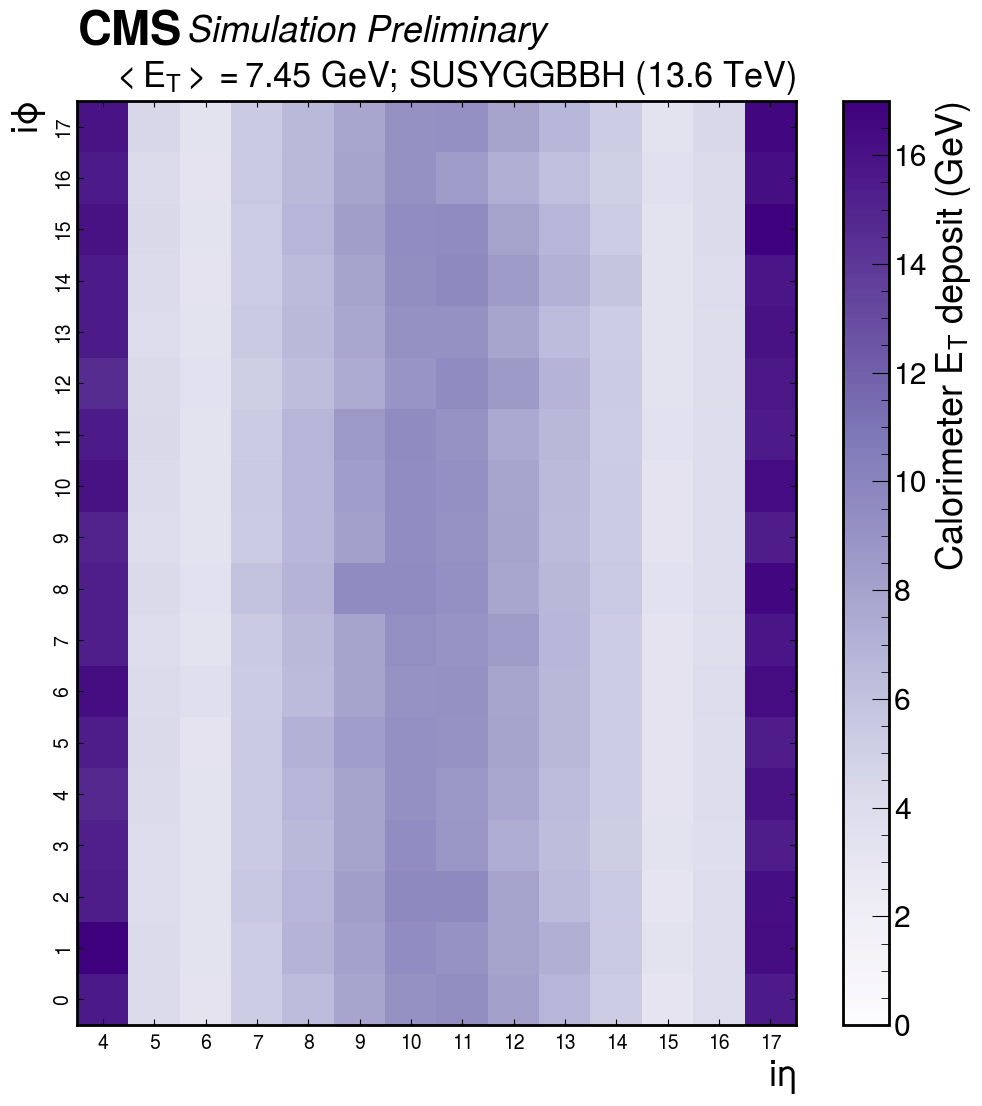

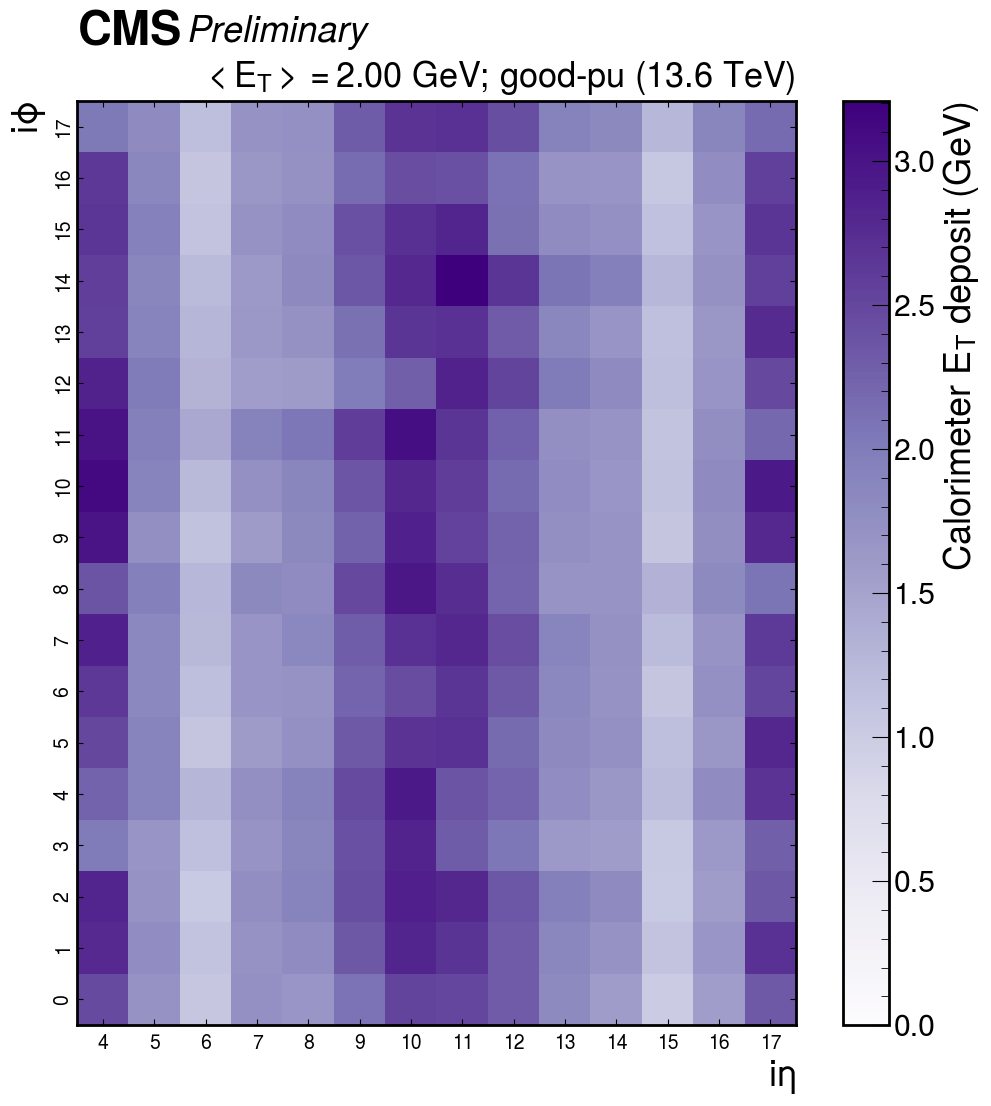

In [658]:
# Profiling training & evaluation data

def plot_regional_deposits(
    deposits: npt.NDArray, mean: float, name: str, is_data: bool = False,
):
    # eta_edges = [0, 0.348, 0.696, 1.044, 1.392, 1.74, 2.172, 3.0]
    # eta_widths = [0.348, 0.348, 0.348, 0.348, 0.348, 0.432, 0.828]
    # eta_edges = [-3.0, -2.172, -1.74, -1.392, -1.044, -0.696, -0.348, 0, 0.348, 0.696, 1.044, 1.392, 1.74, 2.172, 3.0]
    eta_edges = [-3.0,           -1.7,          -1.04,          -0.35,      0.35,         1.04,        1.74,        3.0]

    plt.figure(figsize=(12, 12))

    im = plt.imshow(
        deposits.reshape(18, 14), vmin=0, vmax=deposits.max(), cmap="Purples"
    )
    
    ax = plt.gca()
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(r"Calorimeter E$_T$ deposit (GeV)")
    
    plt.xticks(np.arange(14), labels=np.arange(4, 18), fontsize=14)
    # plt.xticks(
    #     2*np.arange(8)-0.5,
    #     labels=eta_edges
    # )
    # plt.xticks(
    #     [-0.5, 3, 6.5, 10, 13.5],
    #     labels=[-3, -1.39, 0, 1.39, 3]
    # )
    
    plt.yticks(
        np.arange(18),
        labels=np.arange(18)[::-1],
        rotation=90,
        va="center",
        fontsize=14,
    )
    
    plt.xlabel(r"i$\eta$")
    plt.ylabel(r"i$\phi$")

    plt.gca().minorticks_off()
    plt.gca().tick_params(length=4)

    if is_data:
        hep.cms.text('Preliminary', ax=ax, pad=0.05)
    else:
        hep.cms.text('Simulation Preliminary', ax=ax, pad=0.05)

    # verbose title
    if mean is None:
        hep.cms.lumitext(r'(13.6 TeV)', ax=ax)
    else:
        hep.cms.lumitext(rf'$<E_T> = {mean: .2f}$ GeV; {name} (13.6 TeV)')
        # hep.cms.text(rf'$<E_T> = {mean: .2f}$; {name} (13.6 TeV)', ax=ax, pad=0.1)

    save_fig(f'profiling-mean-deposits-{name}')


# # for category, dataset in zip(["Background", "Signal", "Exposure"], [config["background"], config["signal"], config["exposure"]]):
# # for category, dataset in zip(["Signal"], [config["signal"]]):
for category, dataset in zip(["Background", "Signal"], [config["background"], config["signal"]]):

    deposits, labels = get_deposits(dataset)
    labels = [l.replace('2023 ', '') for l in labels]
#     print(labels)

    for name, X in zip(labels, deposits):
        plot_regional_deposits(
            np.mean(X, axis=0).reshape(18, 14), np.mean(X, axis=(0, 1, 2, 3)), name, is_data=(category=='Background')
        )
#         # break

plot_regional_deposits(
    np.mean(X_good_pu, axis=0).reshape(18, 14), np.mean(X_good_pu, axis=(0, 1, 2, 3)), 'good-pu', is_data=True
)

# plot_regional_deposits(
#     np.mean(outlier_train, axis=0).reshape(18, 14), np.mean(outlier_train, axis=(0, 1, 2, 3)), 'outlier-train', is_data=False
# )
# plot_regional_deposits(
#     np.mean(outlier_val, axis=0).reshape(18, 14), np.mean(outlier_val, axis=(0, 1, 2, 3)), 'outlier-val', is_data=False
# )



1/1 [==============================] - 0s 48ms/step


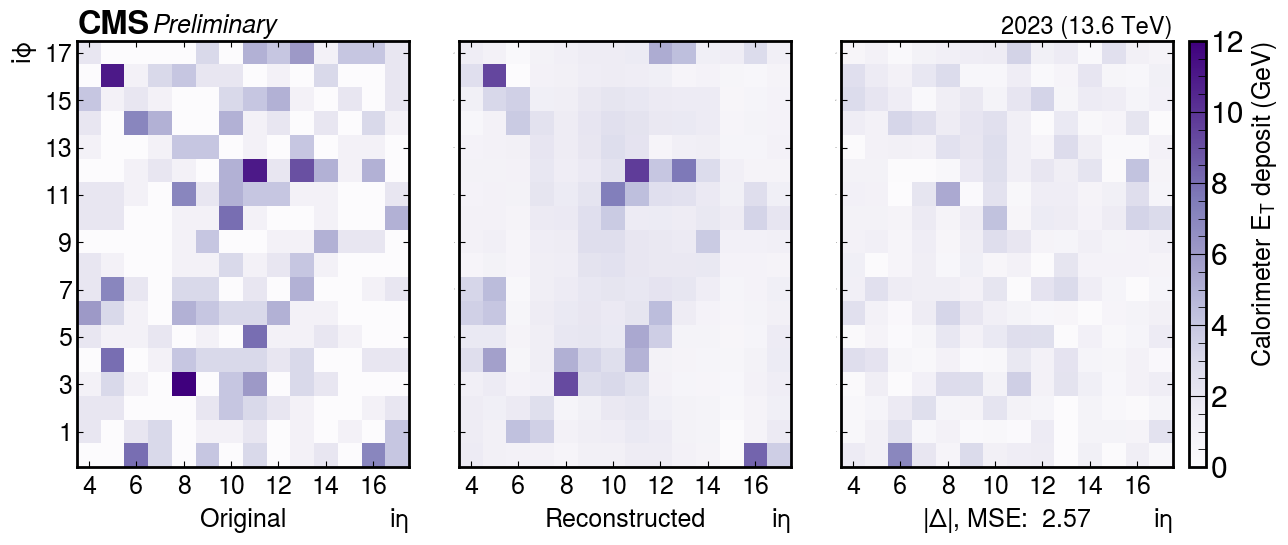

1/1 [==============================] - 0s 5ms/step


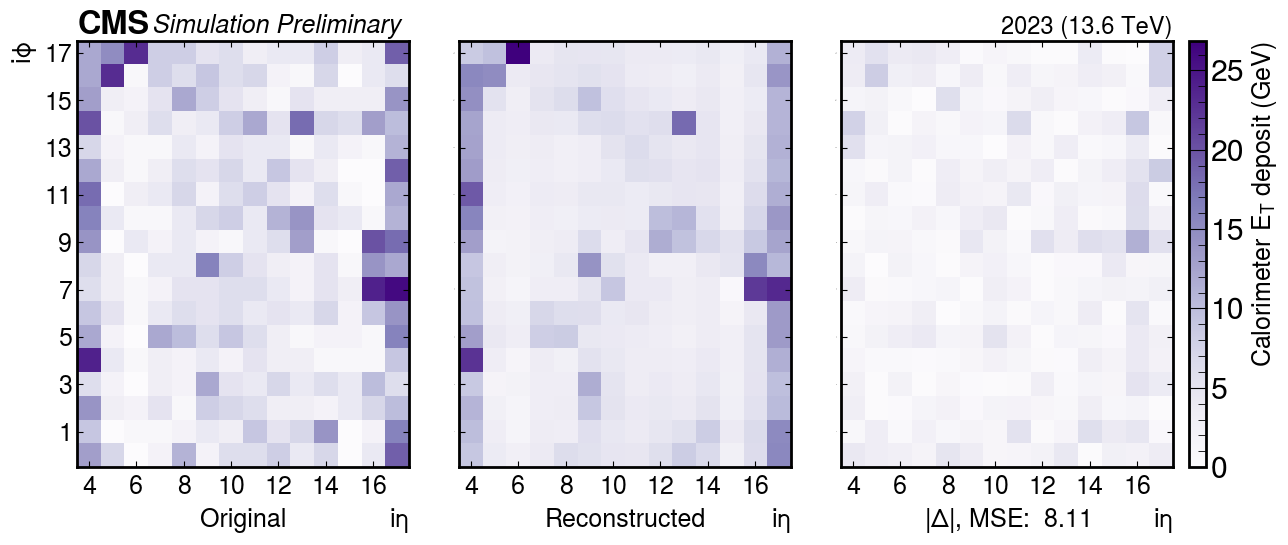

In [418]:
# Comparison between original and reconstructed inputs in single plot

from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

def plot_reconstruction_results(
    deposits_in: npt.NDArray,
    deposits_out: npt.NDArray,
    loss: float,
    name: str,
    is_data: bool = False,
):
    fig, (ax1, ax2, ax3, cax) = plt.subplots(
        ncols=4, figsize=(15, 10), gridspec_kw={"width_ratios": [1, 1, 1, 0.05]}
    )
    max_deposit = max(deposits_in.max(), deposits_out.max())

    if is_data:
        hep.cms.text('Preliminary', ax=ax1, fontsize=18)
    else:
        hep.cms.text('Simulation Preliminary', ax=ax1, fontsize=18)
    hep.cms.lumitext('2023 (13.6 TeV)', ax=ax3, fontsize=18)

    ax1.set_title("Original", fontsize=18, y=-0.16)
    ax1.imshow(
        deposits_in.reshape(18, 14), vmin=0, vmax=max_deposit, cmap="Purples"
    )
    
    ax2.set_title("Reconstructed", fontsize=18, y=-0.16)
    ax2.imshow(
        deposits_out.reshape(18, 14), vmin=0, vmax=max_deposit, cmap="Purples"
    )

    ax3.set_title(rf"|$\Delta$|, MSE: {loss: .2f}", fontsize=18, y=-0.16)
    im = ax3.imshow(
        np.abs(deposits_in - deposits_out).reshape(18, 14),
        vmin=0,
        vmax=max_deposit,
        cmap="Purples",
    )

    ax1.set_ylabel(r"i$\phi$", fontsize=18)
    ax1.set_xlabel(r"i$\eta$", fontsize=18)
    ax2.set_xlabel(r"i$\eta$", fontsize=18)
    ax3.set_xlabel(r"i$\eta$", fontsize=18)

    ax1.set_yticks(range(0, 18)[::2], labels=range(0, 18)[::-2], fontsize=18)
    ax2.set_yticks(range(0, 18)[::2], labels=range(0, 18)[::-2], fontsize=0)
    ax3.set_yticks(range(0, 18)[::2], labels=range(0, 18)[::-2], fontsize=0)

    ax1.set_xticks(range(0, 14, 2), labels=range(4, 18, 2), fontsize=18)
    ax2.set_xticks(range(0, 14, 2), labels=range(4, 18, 2), fontsize=18)
    ax3.set_xticks(range(0, 14, 2), labels=range(4, 18, 2), fontsize=18)
    
    ax1.minorticks_off()
    ax1.tick_params(length=4)
    ax2.minorticks_off()
    ax2.tick_params(length=4)
    ax3.minorticks_off()
    ax3.tick_params(length=4)
 
    ip = InsetPosition(ax3, [1.05, 0, 0.05, 1])
    cax.set_axes_locator(ip)
    fig.colorbar(im, cax=cax, ax=[ax1, ax2, ax3]).set_label(
        label=r"Calorimeter E$_T$ deposit (GeV)", fontsize=18
    )

    save_fig(name)


X_example = X_test[:1]
y_example = teacher.predict(X_example)
plot_reconstruction_results(
    X_example,
    y_example,
    loss=loss(X_example, y_example)[0],
    name="comparison-background",
    is_data=True
)

X_example = X_signal["SUSYGGBBH"][48:49]
y_example = teacher.predict(X_example)
plot_reconstruction_results(
    X_example,
    y_example,
    loss=loss(X_example, y_example)[0],
    name="comparison-signal",
)

1/1 [==============================] - 0s 11ms/step


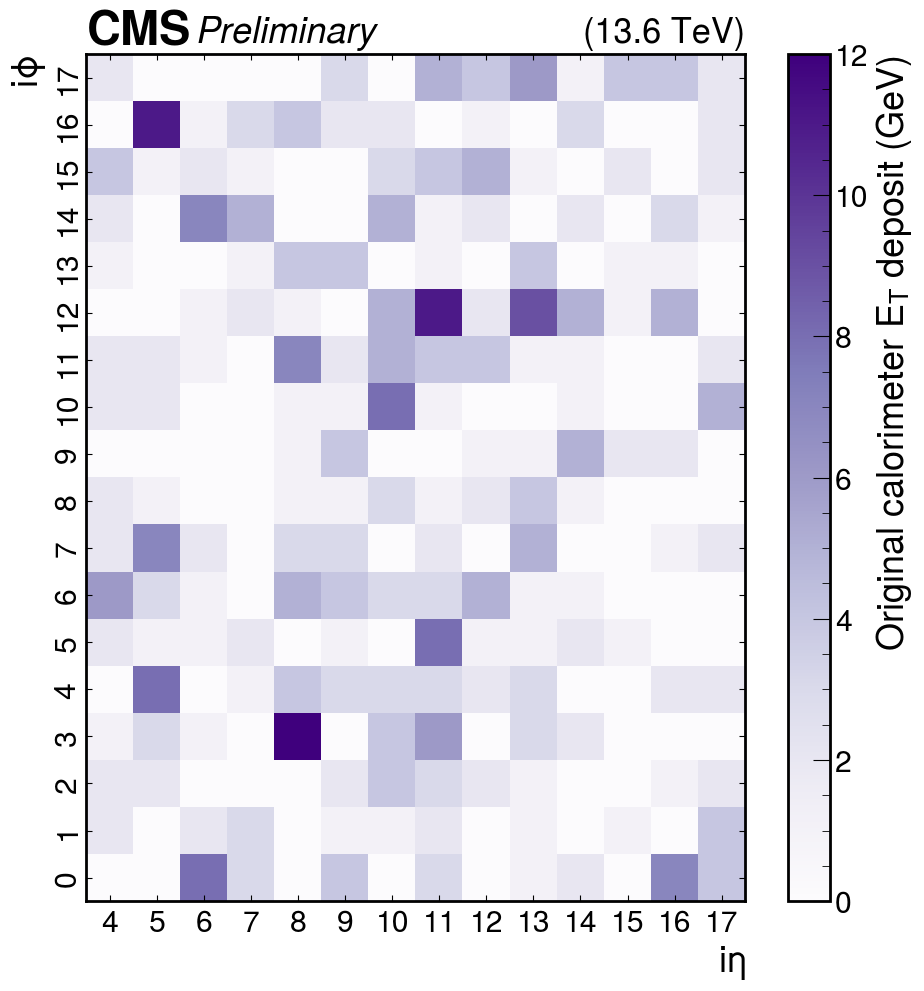

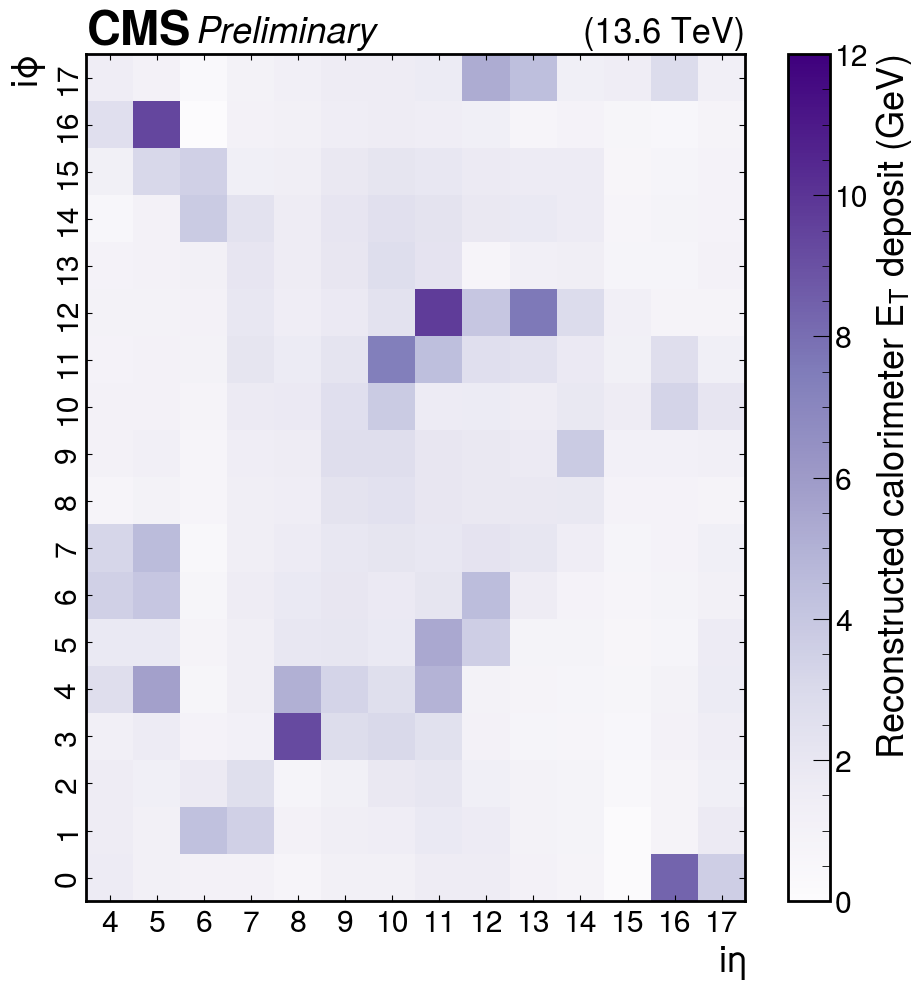

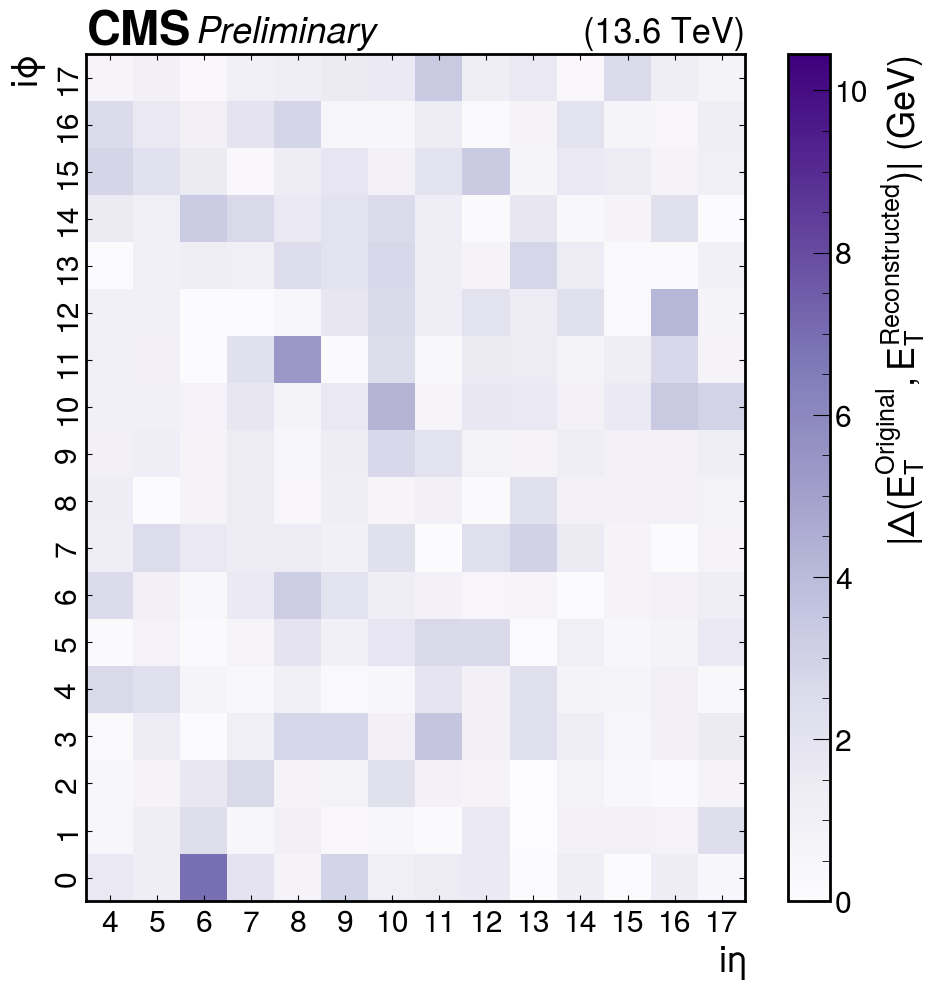

1/1 [==============================] - 0s 10ms/step


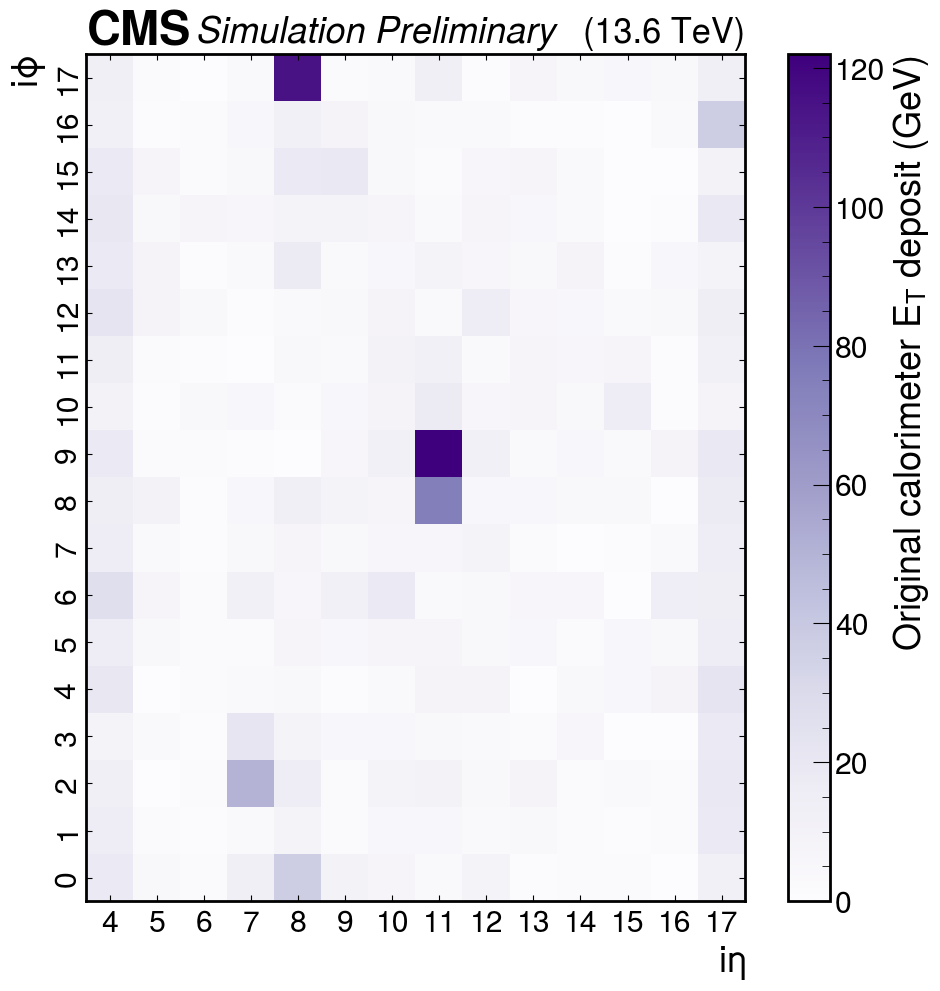

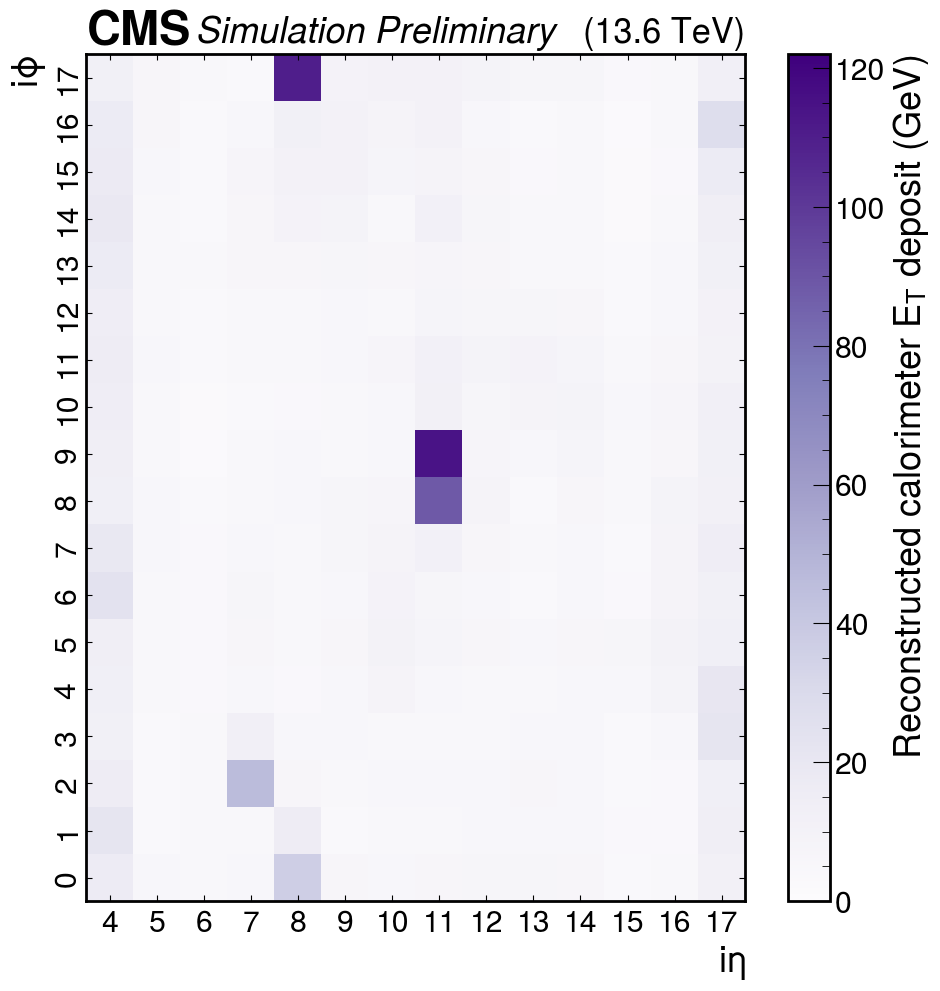

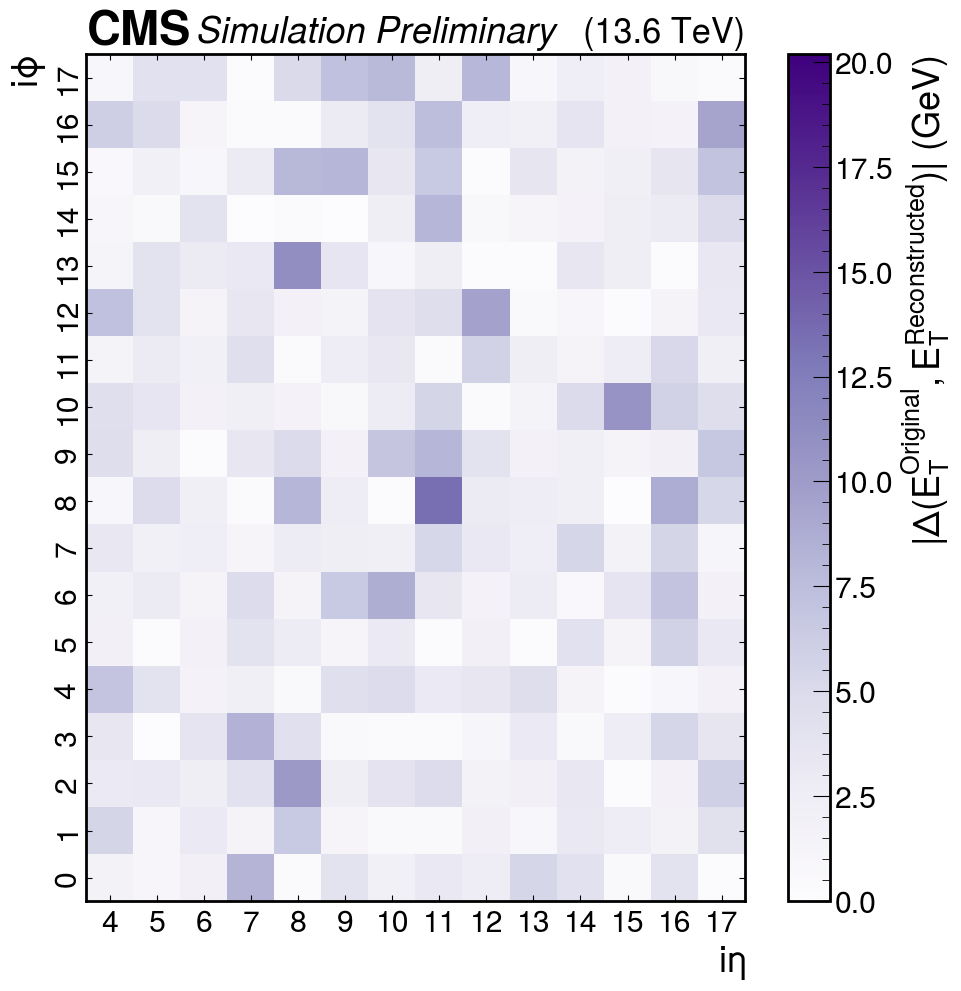

In [661]:
# Comparison between original and reconstructed inputs in three plots
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition


def plot_regional_deposits2(
    deposits: npt.NDArray, mean: float, name: str, is_data: bool = False, ylabel=r"Calorimeter E$_T$ deposit (GeV)", zrange=None
):

    plt.figure(figsize=(11, 11))

    if zrange is None:
        v_min = 0
        v_max = deposits.max()
    else:
        v_min = zrange[0]
        v_max = zrange[1]

    im = plt.imshow(
        deposits.reshape(18, 14), vmin=v_min, vmax=v_max, cmap="Purples"
    )
    
    ax = plt.gca()
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(ylabel)
    
    plt.xticks(np.arange(14), labels=np.arange(4, 18))#, fontsize=14)
    
    plt.yticks(
        np.arange(18),
        labels=np.arange(18)[::-1],
        rotation=90,
        va="center",
        # fontsize=14
    )
    
    plt.xlabel(r"i$\eta$")
    plt.ylabel(r"i$\phi$")

    plt.gca().minorticks_off()
    plt.gca().tick_params(length=4)

    if is_data:
        hep.cms.text('Preliminary', ax=ax)
    else:
        hep.cms.text('Simulation Preliminary', ax=ax)

    # verbose title
    if mean is None:
        hep.cms.lumitext(r'(13.6 TeV)', ax=ax)
    else:
        hep.cms.lumitext(rf'$<E_T> = {mean: .2f}$; {name} 13.6 TeV', ax=ax)

    # short title

    save_fig(f'profiling-mean-deposits-{name}')


X_example = X_test[:1]
y_example = teacher.predict(X_example)
diff = np.abs(X_example - y_example)

zrange = (0, X_example.max())

plot_regional_deposits2(X_example, None, 'reco-example-zb-original', is_data=True, zrange=zrange, ylabel=r"Original calorimeter E$_T$ deposit (GeV)")
plot_regional_deposits2(y_example, None, 'reco-example-zb-reco', is_data=True, zrange=zrange, ylabel=r"Reconstructed calorimeter E$_T$ deposit (GeV)")
plot_regional_deposits2(diff, None, 'reco-example-zb-diff', is_data=True, zrange=(0, diff.max()*1.5), ylabel=r"|$\Delta(E_T^{Original}, E_T^{Reconstructed})|$ (GeV)")

X_example = X_signal["SUSYGGBBH"][:1]
y_example = teacher.predict(X_example)
diff = np.abs(X_example - y_example)

zrange = (0, X_example.max())

plot_regional_deposits2(X_example, None, 'reco-example-signal-original', is_data=False, zrange=zrange, ylabel=r"Original calorimeter E$_T$ deposit (GeV)")
plot_regional_deposits2(y_example, None, 'reco-example-signal-reco', is_data=False, zrange=zrange, ylabel=r"Reconstructed calorimeter E$_T$ deposit (GeV)")
plot_regional_deposits2(diff, None, 'reco-example-signal-diff', is_data=False, zrange=(0, diff.max()*1.5), ylabel=r"|$\Delta(E_T^{Original}, E_T^{Reconstructed})|$ (GeV)")

# plot_reconstruction_results(
#     X_example,
#     y_example,
#     loss=loss(X_example, y_example)[0],
#     name="comparison-background",
#     is_data=True
# )

# X_example = X_signal["SUSYGGBBH"][48:49]
# y_example = teacher.predict(X_example)
# plot_reconstruction_results(
#     X_example,
#     y_example,
#     loss=loss(X_example, y_example)[0],
#     name="comparison-signal",
# )

In [18]:
# calculate model predictions

y_pred_background_teacher = teacher.predict(X_test, batch_size=512)
y_loss_background_teacher = loss(X_test, y_pred_background_teacher)
y_loss_background_cicada_v2 = cicada_v2.predict(X_test.reshape(-1, 252, 1), batch_size=512)

y_pred_background_good_pu_teacher = teacher.predict(X_good_pu, batch_size=512)
y_loss_background_good_pu_teacher = loss(X_good_pu, y_pred_background_good_pu_teacher)
y_loss_background_good_pu_cicada_v2 = cicada_v2.predict(X_good_pu.reshape(-1, 252, 1), batch_size=512)

results_teacher, results_cicada_v1, results_cicada_v2 = dict(), dict(), dict()
results_teacher["2023 Zero Bias"] = y_loss_background_teacher
results_cicada_v2["2023 Zero Bias"] = y_loss_background_cicada_v2
results_teacher["2024 ZB (Good PU)"] = y_loss_background_good_pu_teacher
results_cicada_v2["2024 ZB (Good PU)"] = y_loss_background_good_pu_cicada_v2

y_true, y_pred_teacher, y_pred_cicada_v2, y_true_good_pu, y_pred_teacher_good_pu, y_pred_cicada_v2_good_pu = [], [], [], [], [], []
inputs, inputs_good_pu = [], []
for name, data in X_signal.items():
    inputs.append(np.concatenate((data, X_test)))
    inputs_good_pu.append(np.concatenate((data, X_good_pu)))

    y_loss_teacher = loss(
        data, teacher.predict(data, batch_size=512)
    )
    y_loss_cicada_v2 = cicada_v2.predict(data.reshape(-1, 252, 1), batch_size=512)
    results_teacher[name] = y_loss_teacher
    results_cicada_v2[name] = y_loss_cicada_v2
    y_true.append(
        np.concatenate((np.ones(data.shape[0]), np.zeros(X_test.shape[0])))
    )
    y_pred_teacher.append(
        np.concatenate((y_loss_teacher, y_loss_background_teacher))
    )
    y_pred_cicada_v2.append(
        np.concatenate((y_loss_cicada_v2, y_loss_background_cicada_v2))
    )
    
    y_true_good_pu.append(
        np.concatenate((np.ones(data.shape[0]), np.zeros(X_good_pu.shape[0])))
    )
    y_pred_teacher_good_pu.append(
        np.concatenate((y_loss_teacher, y_loss_background_good_pu_teacher))
    )
    y_pred_cicada_v2_good_pu.append(
        np.concatenate((y_loss_cicada_v2, y_loss_background_good_pu_cicada_v2))
    )

194/194 [==============================] - 0s 1ms/step


In [29]:
cmap = {
    "2023 Zero Bias": "tab:blue",
    "SUEP": "orange",
    "HtoLongLived": "green",
    "VBFHto2C": "red",
    "TT": "purple",
    "SUSYGGBBH": "brown"
}

label = SUEP
weight =
[1. 1. 1. ... 1. 1. 1.]
label = HtoLongLived
weight =
[1. 1. 1. ... 1. 1. 1.]
label = VBFHto2C
weight =
[1. 1. 1. ... 1. 1. 1.]
label = TT
weight =
[1. 1. 1. ... 1. 1. 1.]
label = SUSYGGBBH
weight =
[1. 1. 1. ... 1. 1. 1.]


/var/folders/rm/c4v4r2pj4zg9qd1xxw_8mzn80000gn/T/ipykernel_48544/647887987.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabel)


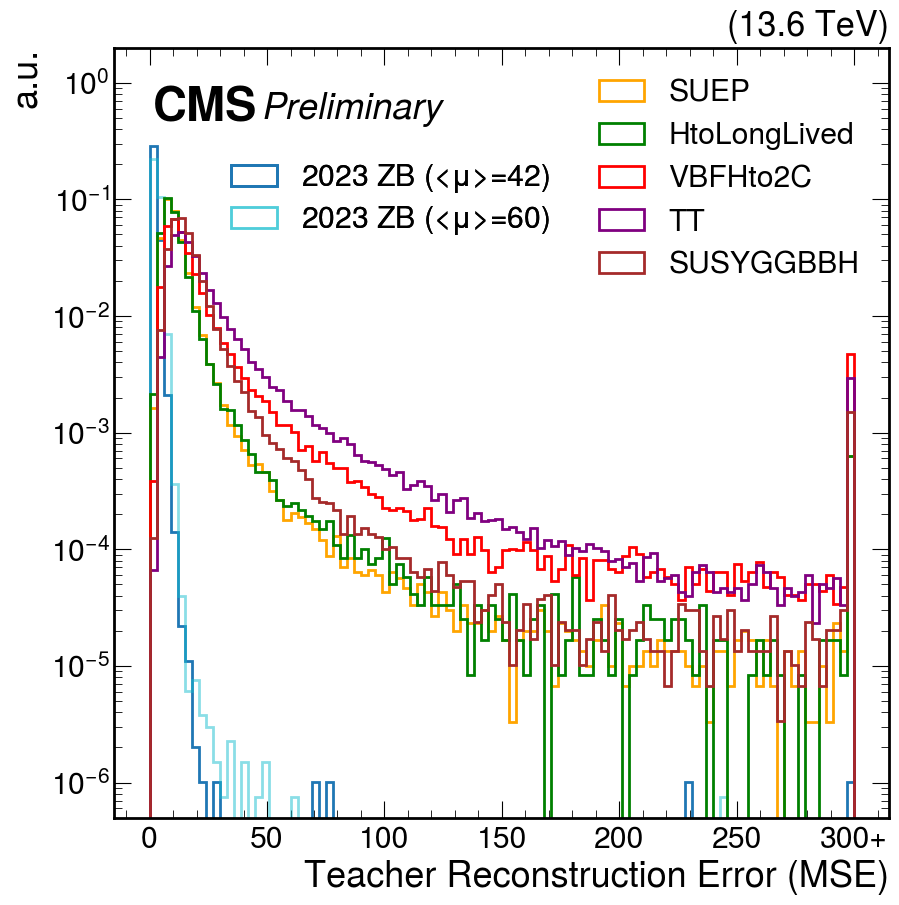

In [30]:
# plot teacher mse dist
hep.style.use('CMS')


def plot_mse_distribution(
    scores: List[npt.NDArray], labels: List[str], name: str, weights = None
):
    # plt.figure(figsize=(8, 8))
    if weights is None:
        weights = {l: np.ones_like(s) for l, s in zip(labels, scores)}

    hs = {}
    bins = np.arange(0, 303, 3)

    label = '2023 Zero Bias'
    idx = labels.index(label)
    score = scores[idx]
    _, _, hs[label] = plt.hist(
        np.clip(score, bins[0], bins[-1]),
        bins=bins,
        density=1,
        # label=label,
        label=r'2023 ZB (<$\mu$>=42)',
        # label=r'2023 ZB',
        log=True,
        histtype="step",
        linewidth=2,
        color=cmap['2023 Zero Bias']
    )

    label = '2024 ZB (Good PU)'
    idx = labels.index(label)
    score = scores[idx]
    _, _, hs[label] = plt.hist(
        np.clip(score, bins[0], bins[-1]),
        bins=bins,
        density=1,
        # label=label,
        label=r'2023 ZB (<$\mu$>=60)',
        log=True,
        histtype="step",
        linewidth=2,
        # color=cmap['2023 Zero Bias'],
        color='tab:cyan',
        alpha=0.5
    )  
    
    for score, label in zip(scores, labels):
        if 'Zero Bias' in label or 'ZB' in label:
            # weight = np.ones_like(score)
            continue
        else:
            weight = weights[label]
        print(f'label = {label}')
        print(f'weight =\n{weight}')
        _, _, hs[label] = plt.hist(
            np.clip(score, bins[0], bins[-1]),
            bins=bins,
            weights=weight,
            density=1,
            label=label,
            log=True,
            histtype="step",
            linewidth=2,
            color=cmap[label]
        )
    plt.xlabel("Teacher Reconstruction Error (MSE)")
    plt.ylabel("a.u.")
    ax = plt.gca()
    # ylim = ax.get_ylim()
    # ax.set_ylim(ylim[0], 3*ylim[1])
    ax.set_ylim(0.0000005, 2)
    xticklabel = ax.get_xticklabels()
    xticklabel[-2] = xticklabel[-2].get_text() + '+'
    ax.set_xticklabels(xticklabel)

    signal_keys, data_keys = [], []
    for k in hs.keys():
        if 'ZB' in k or 'Zero Bias' in k:
            data_keys.append(k)
        else:
            signal_keys.append(k)

    l1 = ax.legend(handles=[hs[k][0] for k in signal_keys], loc="lower right", bbox_to_anchor=(1.0, 0.66))
    l2 = ax.legend(handles=[hs[k][0] for k in data_keys], loc="lower right", bbox_to_anchor=(0.6, 0.715), labelspacing=0.3)

    ax.add_artist(l1)
    ax.add_artist(l2)

    # plt.legend(loc="upper right", frameon=False)

    hep.cms.text('Preliminary', loc=1)
    hep.cms.lumitext(r'(13.6 TeV)')

    save_fig(name)

plot_mse_distribution(
    list(results_teacher.values()),
    [*results_teacher],
    "mse-dist-teacher-pu",
    # "mse-dist-teacher",
)

# plot_mse_distribution(
#     list(results_teacher.values()),
#     [*results_teacher],
#     "mse-dist-teacher-pu-weighted",
#     weights=pu_weights
# )

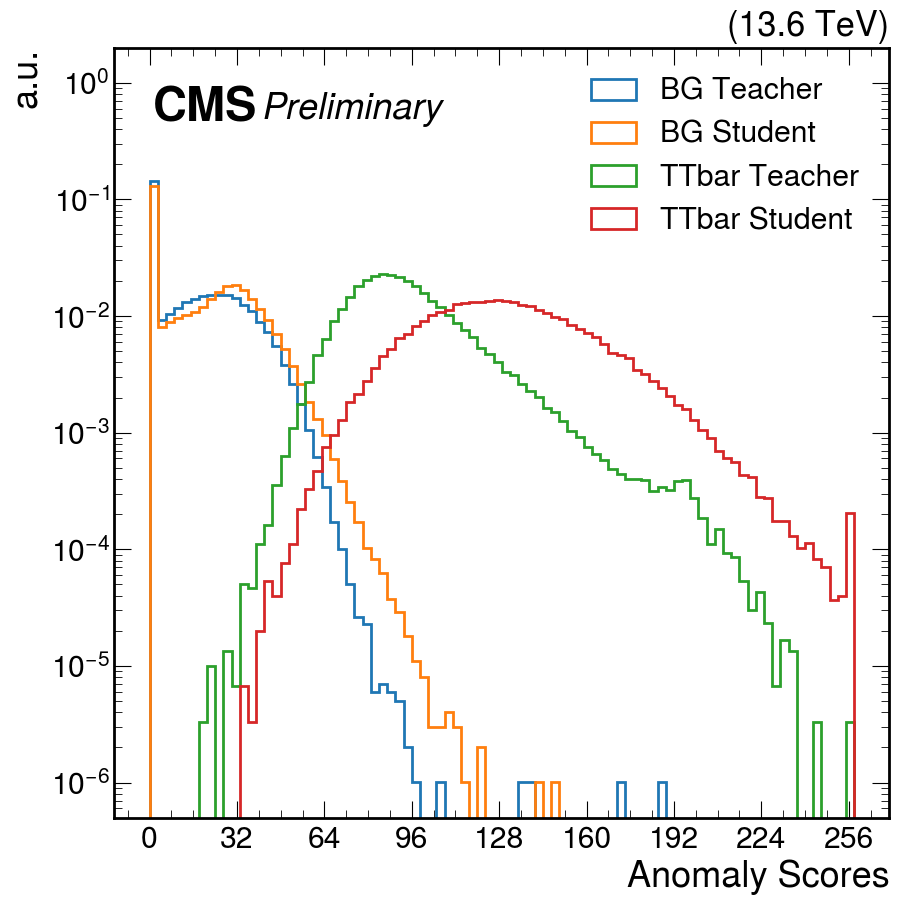

In [43]:
def plot_anomaly_score_distribution(
    scores: List[npt.NDArray], labels: List[str], name: str, xlabel=r"Anomaly Score", weights=None
):
    for score, label in zip(scores, labels):
        plt.hist(
            score.reshape((-1)),
            bins=range(0, 259, 3),
            # range=(0, 257),
            density=1,
            label=label,
            log=True,
            histtype="step",
            linewidth=2,
        )

    plt.xlabel(xlabel)
    plt.ylabel("a.u.")
    ax = plt.gca()
    # ylim = ax.get_ylim()
    # ax.set_ylim(ylim[0], 40*ylim[1])
    ax.set_ylim(0.0000005, 2)
    ax.set_xticks(range(0, 280, 32))    
    
    plt.legend(loc="upper right")
 
    hep.cms.text('Preliminary', loc=1)
    hep.cms.lumitext(r'(13.6 TeV)')
    
    save_fig(name)


plot_anomaly_score_distribution(
    # [quantize(np.log(y)*32) for y in [results_teacher['2023 Zero Bias'], results_cicada_v2['2023 Zero Bias']]],
    [quantize(np.log(results_teacher['2023 Zero Bias'])*32), results_cicada_v2['2023 Zero Bias'], quantize(np.log(results_teacher['TT'])*32), results_cicada_v2['TT']],
    ["BG Teacher", "BG Student", "TTbar Teacher", "TTbar Student"],
    "anomaly-score-teacher-and-student",
    # "anomaly-score-teacher",
    r"Anomaly Scores"
)


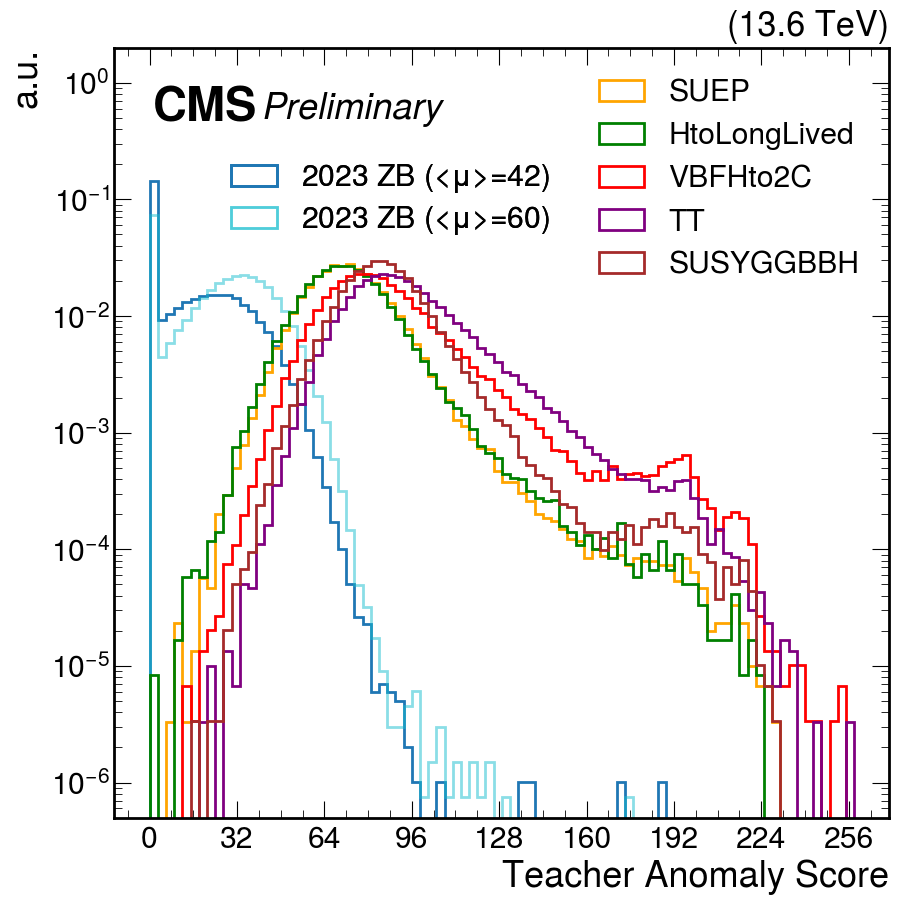

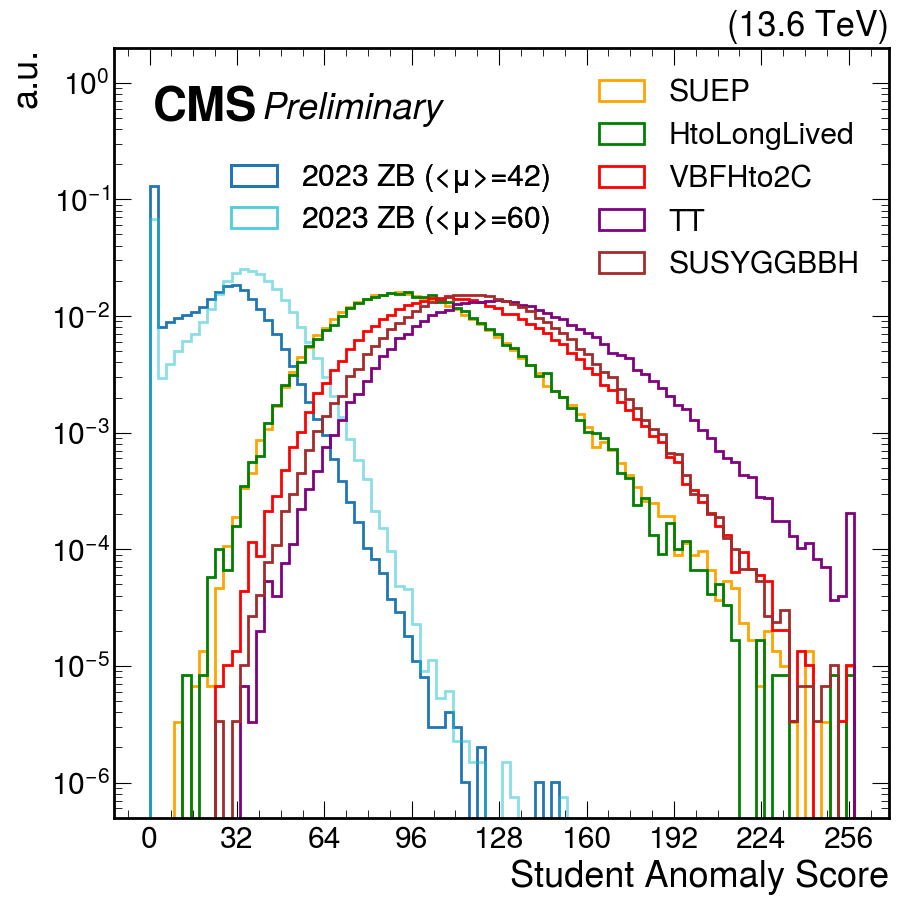

In [34]:
# plot anomaly scores

def plot_anomaly_score_distribution(
    scores: List[npt.NDArray], labels: List[str], name: str, xlabel=r"Anomaly Score", weights=None
):
    if weights is None:
        weights = {l: np.ones_like(s) for l, s in zip(labels, scores)}

    hs = {}

    label = '2023 Zero Bias'
    idx = labels.index(label)
    score = scores[idx]
    _, _, hs[label] = plt.hist(
        score.reshape((-1)),
        bins=range(0, 259, 3),
        density=1,
        # label=label,
        label=r'2023 ZB (<$\mu$>=42)',
        # label=r'2023 ZB',
        log=True,
        histtype="step",
        linewidth=2,
        color=cmap['2023 Zero Bias']
    )

    label = '2024 ZB (Good PU)'
    idx = labels.index(label)
    score = scores[idx]
    _, _, hs[label] = plt.hist(
        score.reshape((-1)),
        bins=range(0, 259, 3),
        density=1,
        # label=label,
        label=r'2023 ZB (<$\mu$>=60)',
        log=True,
        histtype="step",
        linewidth=2,
        # color=cmap['2023 Zero Bias'],
        color='tab:cyan',
        alpha=0.5
    )    

    for score, label in zip(scores, labels):
        if 'Zero Bias' in label or 'ZB' in label:
            # weight = np.ones_like(score)
            continue
        else:
            weight = weights[label]

        _,_, hs[label] = plt.hist(
            score.reshape((-1)),
            bins=range(0, 259, 3),
            # range=(0, 257),
            density=1,
            weights=weight,
            label=label,
            log=True,
            histtype="step",
            linewidth=2,
            color=cmap[label]
        )

    plt.xlabel(xlabel)
    plt.ylabel("a.u.")
    ax = plt.gca()

    signal_keys, data_keys = [], []
    for k in hs.keys():
        if 'ZB' in k or 'Zero Bias' in k:
            data_keys.append(k)
        else:
            signal_keys.append(k)
        
    l1 = ax.legend(handles=[hs[k][0] for k in signal_keys], loc="lower right", bbox_to_anchor=(1.0, 0.66))
    l2 = ax.legend(handles=[hs[k][0] for k in data_keys], loc="lower right", bbox_to_anchor=(0.6, 0.715), labelspacing=0.3)
    ax.add_artist(l1)
    ax.add_artist(l2)
    # ylim = ax.get_ylim()
    # ax.set_ylim(ylim[0], 40*ylim[1])
    ax.set_ylim(0.0000005, 2)
    ax.set_xticks(range(0, 280, 32))    
    
    # plt.legend(loc="upper right")
 
    
    hep.cms.text('Preliminary', loc=1)
    hep.cms.lumitext(r'(13.6 TeV)')
    
    save_fig(name)

plot_anomaly_score_distribution(
    [quantize(np.log(y)*32) for y in results_teacher.values()],
    [*results_teacher],
    "anomaly-score-teacher-pu",
    # "anomaly-score-teacher",
    r"Teacher Anomaly Score"
)
plot_anomaly_score_distribution(
    list(results_cicada_v2.values()),
    [*results_cicada_v2],
    "anomaly-score-cicada-v2-pu",
    # "anomaly-score-cicada-v2",
    r"Student Anomaly Score"
)

# plot_anomaly_score_distribution(
#     [quantize(np.log(y)*32) for y in results_teacher.values()],
#     [*results_teacher],
#     "anomaly-score-teacher-pu-weighted",
#     r"Teacher Anomaly Score",
#     weights=weights_dict
# )
# plot_anomaly_score_distribution(
#     list(results_cicada_v2.values()),
#     [*results_cicada_v2],
#     "anomaly-score-cicada-v2-pu-weighted",
#     r"Student Anomaly Score",
#     weights=weights_dict
# )

# plot_anomaly_score_distribution(
#     [quantize(np.log(y)*32) for y in results_teacher.values()],
#     [*results_teacher],
#     "anomaly-score-teacher-pu-weighted-clip",
#     r"Teacher Anomaly Score",
#     weights=weights_dict_clipped
# )
# plot_anomaly_score_distribution(
#     list(results_cicada_v2.values()),
#     [*results_cicada_v2],
#     "anomaly-score-cicada-v2-pu-weighted-clip",
#     r"Student Anomaly Score",
#     weights=weights_dict_clipped
# )

# plot_anomaly_score_distribution(
#     [quantize(np.log(y)*32) for y in results_teacher.values()],
#     [*results_teacher],
#     "anomaly-score-teacher-pu-weighted-cut",
#     r"Teacher Anomaly Score",
#     weights=weights_dict_cut
# )
# plot_anomaly_score_distribution(
#     list(results_cicada_v2.values()),
#     [*results_cicada_v2],
#     "anomaly-score-cicada-v2-pu-weighted-cut",
#     r"Student Anomaly Score",
#     weights=weights_dict_cut
# )

In [108]:
# calculate model predictions for outliers




# # y_true, y_pred_teacher, y_pred_cicada_v1, y_pred_cicada_v2 = [], [], [], []
# # inputs = []
# for name, data in X_signal.items():

    
#     inputs.append(np.concatenate((data, X_test)))

#     y_loss_teacher = loss(
#         data, teacher.predict(data, batch_size=512)
#     )
#     y_loss_cicada_v2 = cicada_v2.predict(data.reshape(-1, 252, 1), batch_size=512)
#     results_teacher[name] = y_loss_teacher
#     results_cicada_v2[name] = y_loss_cicada_v2

#     y_true.append(
#         np.concatenate((np.ones(data.shape[0]), np.zeros(X_test.shape[0])))
#     )
#     y_pred_teacher.append(
#         np.concatenate((y_loss_teacher, y_loss_background_teacher))
#     )
#     y_pred_cicada_v2.append(
#         np.concatenate((y_loss_cicada_v2, y_loss_background_cicada_v2))
    # )

In [105]:
pu_factor_dict = {}
for proc in ['HtoLongLived', 'SUEP', 'TT', 'VBFHto2C', 'SUSYGGBBH']:
    with open(f'data/PU-factors/{proc}_PU_Factors.json', 'r') as f:
        pu_factor_dict[proc] = json.load(f)

pu_weights = {}
for proc in nPV_signal.keys():
    weights = []
    for npv in nPV_signal[proc]:
        if npv > 100 or npv == 0:
            weights.append(0)
        else:
            weights.append(pu_factor_dict[proc][str(int(npv))])
    pu_weights[proc] = np.array(weights)

# pu_weights['2023 Zero Bias'] = 

for k, v in pu_weights.items():
    print(f'k = {k}, v.shape = {v.shape}')

k = SUEP, v.shape = (100000,)
k = HtoLongLived, v.shape = (40000,)
k = VBFHto2C, v.shape = (98985,)
k = TT, v.shape = (100067,)
k = SUSYGGBBH, v.shape = (98899,)


In [109]:
# # plot teacher & student dist in one plot
# loss_teacher_outlier = loss(
#     outlier_train, teacher.predict(outlier_train, batch_size=512)
# )
# loss_cicada_v2_outlier = cicada_v2.predict(outlier_train.reshape(-1, 252, 1), batch_size=512)

# loss_teacher_bg_train = loss(
#     X_train, teacher.predict(X_train, batch_size=512)
# )
# loss_cicada_v2_bg_train = cicada_v2.predict(X_train.reshape(-1, 252, 1), batch_size=512)


bg_teacher = quantize(np.log(results_teacher['2023 Zero Bias'])*32)
bg_train_teacher = quantize(np.log(loss_teacher_bg_train)*32)
sig_teacher = np.concatenate([quantize(np.log(r)*32) for r in results_teacher.values()])
outlier_teacher = quantize(np.log(loss_teacher_outlier)*32)

bg_cicada_v2 = results_cicada_v2['2023 Zero Bias']
sig_cicada_v2 = np.concatenate(list(results_cicada_v2.values()))

plot_anomaly_score_distribution(
    # [bg_teacher, sig_teacher, bg_cicada_v2, sig_cicada_v2, outlier_teacher, loss_cicada_v2_outlier],
    [bg_teacher, bg_cicada_v2, outlier_teacher, loss_cicada_v2_outlier],
    # [bg_teacher, bg_cicada_v2, bg_train_teacher, loss_cicada_v2_bg_train],
    # ['Zero Bias (Teacher)', 'Signal (Teacher)', 'Zero Bias (Student)', 'Signal (Student)', 'Outlier (Teacher)', 'Outlier (Student)'],
    ['Zero Bias (Teacher)', 'Zero Bias (Student)', 'Outlier (Teacher)', 'Outlier (Student)'],
    # ['Train (Teacher)', 'Train (Student)', 'Val (Teacher)', 'Val (Student)'],
    'anomaly-score-background-outlier',
)
# plot_anomaly_score_distribution(
#     [quantize(np.log(results_teacher[k])*32) for k in keys] + [results_cicada_v2[k] for k in keys],
#     ['2023 Zero Bias (Teacher)', '2023 Zero Bias (Student)', 'a', 'b'],
#     "anomaly-score-teacher",
# )
# plot_anomaly_score_distribution(
#     list(results_cicada_v2.values()),
#     [*results_cicada_v2],
#     "anomaly-score-cicada-v2",
# )

NameError: name 'loss_teacher_bg_train' is not defined

_ = [481.9715  430.62366 366.57834 191.9143  146.53047]
_ = [481.9715  430.62366 366.57834 191.9143  146.53047]
_ = [481.9715  430.62366 366.57834 191.9143  146.53047]
_ = [481.9715  430.62366 366.57834 191.9143  146.53047]
_ = [481.9715  430.62366 366.57834 191.9143  146.53047]


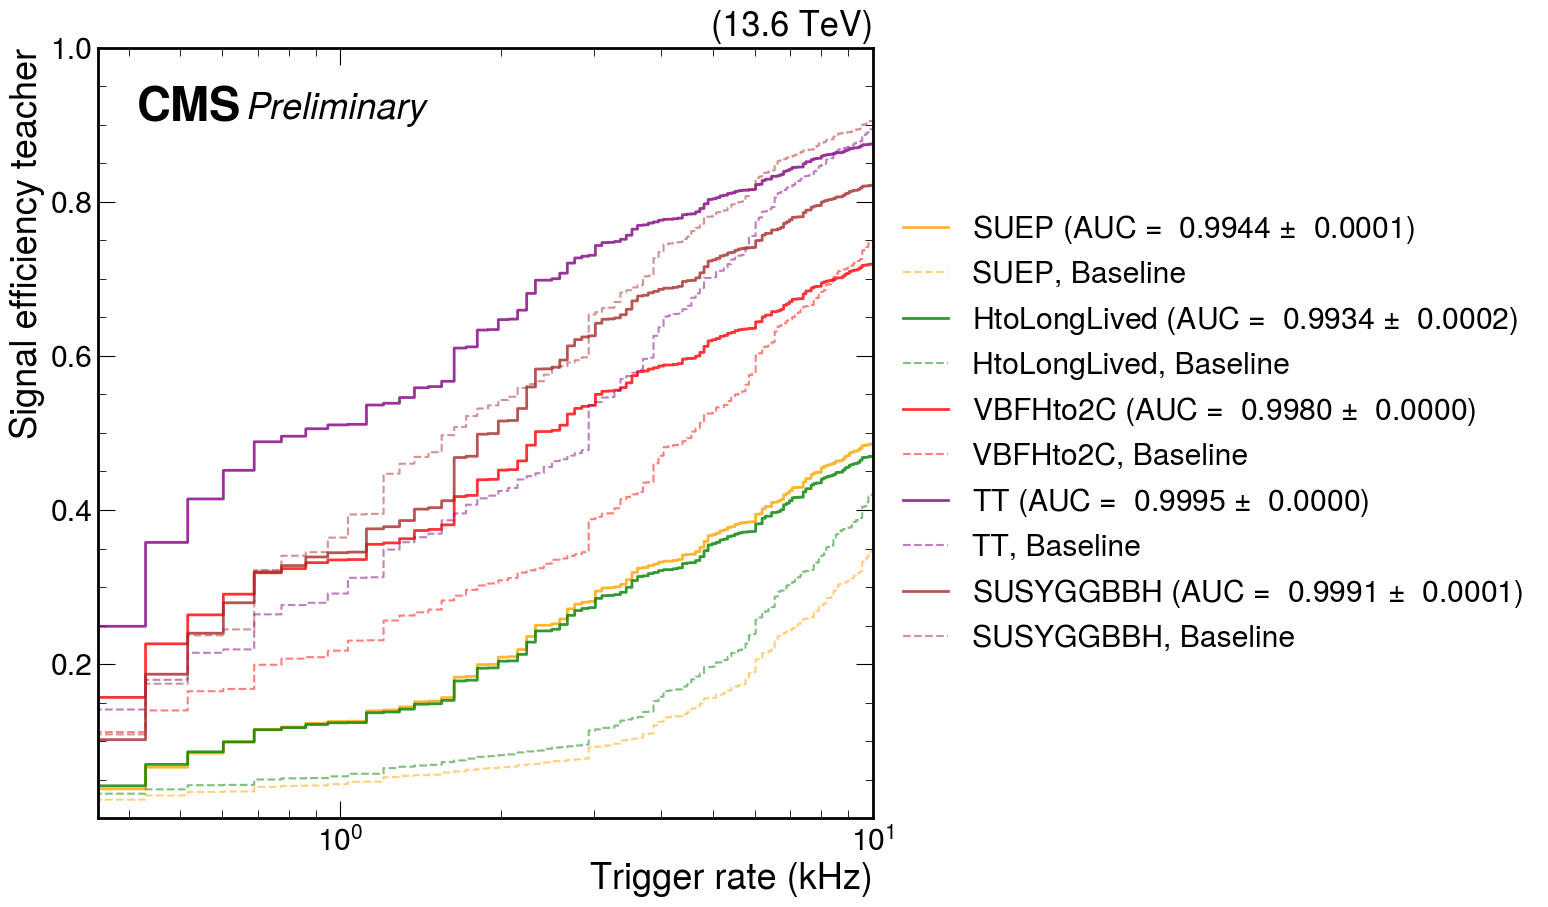

_ = [447.03125 335.27344 223.51562 111.75781   0.     ]
_ = [447.03125 335.27344 223.51562 111.75781   0.     ]
_ = [447.03125 335.27344 223.51562 111.75781   0.     ]
_ = [447.03125 335.27344 223.51562 111.75781   0.     ]
_ = [447.03125 335.27344 223.51562 111.75781   0.     ]


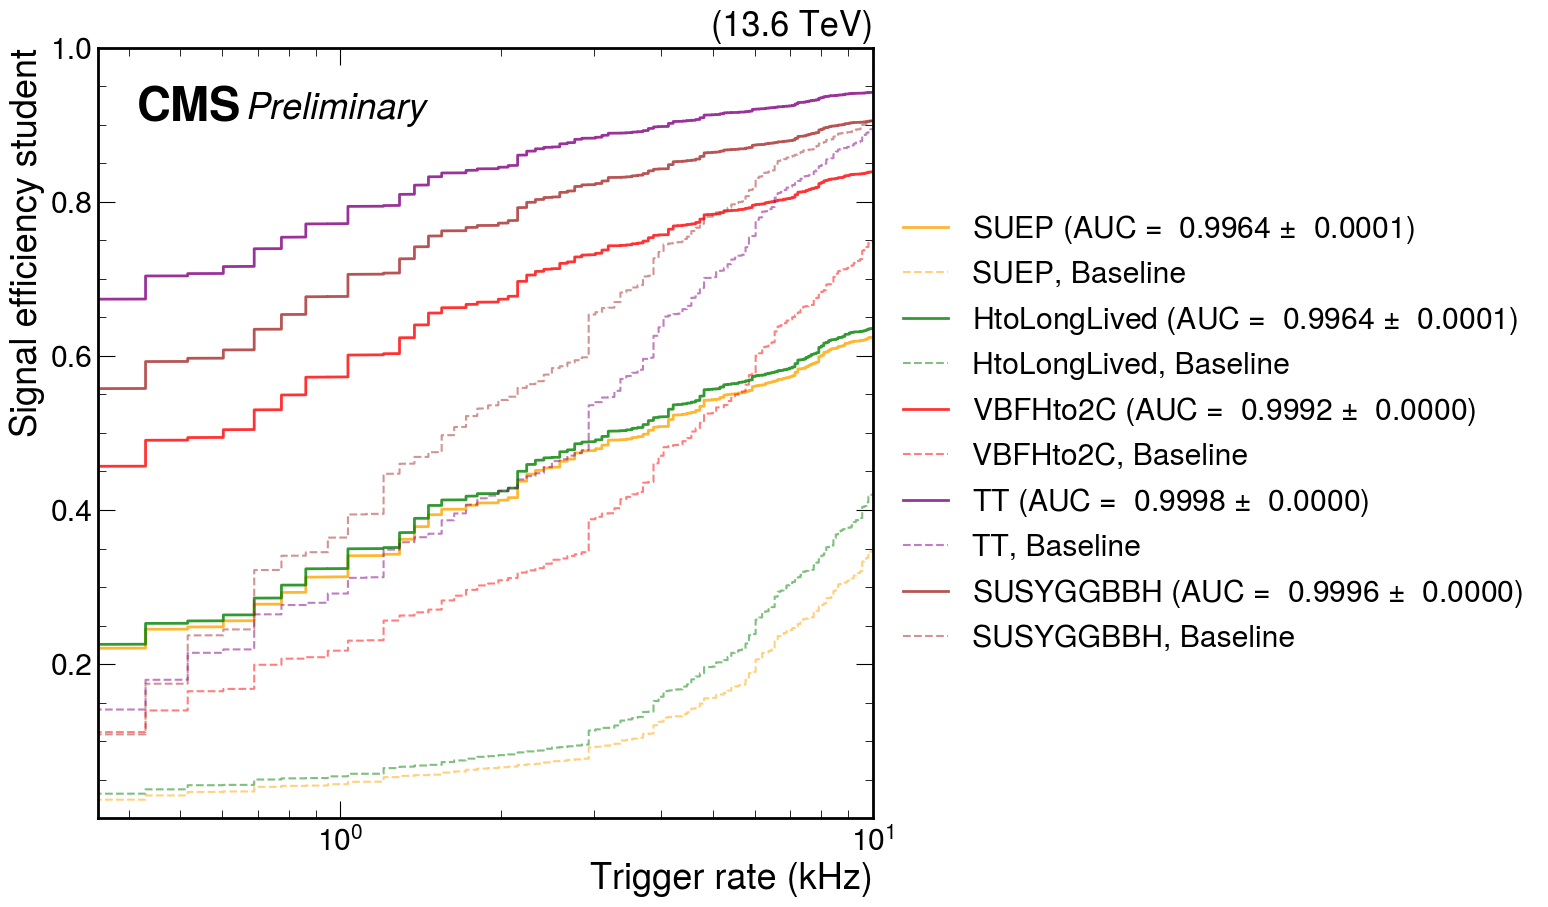

In [20]:
# plot roc curves
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
cmap = ["green", "red", "blue", "orange", "purple", "brown"]

cmap = {
    "2023 Zero Bias": "tab:blue",
    "SUEP": "orange",
    "HtoLongLived": "green",
    "VBFHto2C": "red",
    "TT": "purple",
    "SUSYGGBBH": "brown"
}

# def get_aucs(
#     y_trues: List[npt.NDArray],
#     y_preds: List[npt.NDArray],
#     labels: List[str],
#     inputs: List[npt.NDArray],
#     name: str,
#     cv: int = 3,
#     baseline: str = 'mean'
# ):
#     skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
#     base_line_alg = {
#         'mean': lambda x: np.mean(x**2, axis=(1, 2)),
#         'max': lambda x: np.max(x**2, axis=(1, 2))
#     }[baseline]
#     roc_auc, roc_auc_std = [], []
#     for y_true, y_pred, label, color, d in zip(
#         y_trues, y_preds, labels, cmap, inputs
#     ):
#         aucs = []
#         for _, indices in skf.split(y_pred, y_true):
#             fpr, tpr, _ = roc_curve(y_true[indices], y_pred[indices])
#             aucs.append(auc(fpr, tpr))
#         roc_auc_std.append(np.std(aucs))
#         fpr, tpr, _ = roc_curve(y_true, y_pred)
#         roc_auc.append(auc(fpr, tpr))

#     return roc_auc, roc_auc_std


def plot_roc_curve(
    y_trues: List[npt.NDArray],
    y_preds: List[npt.NDArray],
    labels: List[str],
    inputs: List[npt.NDArray],
    name: str,
    cv: int = 3,
    baseline: str = 'mean',
    ylabel: str = "Signal efficiency",
    weights: dict = None
):

    if weights is None:
        weights = {l: np.ones_like(y) for l, y in zip(labels, y_preds)}

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    base_line_alg = {
        'mean': lambda x: np.mean(x**2, axis=(1, 2)),
        'max': lambda x: np.max(x**2, axis=(1, 2))
    }[baseline]
    for y_true, y_pred, label, color, d in zip(
        y_trues, y_preds, labels, cmap, inputs
    ):
        aucs = []
        for _, indices in skf.split(y_pred, y_true):
            fpr, tpr, _ = roc_curve(y_true[indices], y_pred[indices], sample_weight=weights[label][indices])
            aucs.append(auc(fpr, tpr))
        std_auc = np.std(aucs)

        fpr, tpr, _ = roc_curve(y_true, y_pred, drop_intermediate=False, sample_weight=weights[label])
        print(f'_ = {_[-5:]*28610}')
        roc_auc = auc(fpr, tpr)
        fpr_base, tpr_base, _ = roc_curve(y_true, base_line_alg(d), drop_intermediate=False, sample_weight=weights[label])

        plt.plot(
            fpr * 28610,
            tpr,
            linestyle="-",
            lw=2,
            color=cmap[label],
            alpha=0.8,
            label=rf"{label} (AUC = {roc_auc: .4f} $\pm$ {std_auc: .4f})",
        )

        plt.plot(
            fpr_base * 28610,
            tpr_base,
            linestyle="--",
            lw=1.5,
            color=cmap[label],
            alpha=0.5,
            label=rf"{label}, Baseline",
        )

    # plt.plot(
    #     [3, 3],
    #     [0, 1],
    #     linestyle="--",
    #     lw=1,
    #     color="black",
    #     label="3 kHz",
    # )
    # plt.xlim([0.0002861, 28.61])
    # plt.xlim([0.2861, 10])
    plt.xlim([0.35, 10])
    plt.ylim([0.001, 1.0])
    # plt.ylim([0.001, 1.1])
    # plt.ylim([0., 1.0])
    plt.xscale("log")
    # plt.yscale("log")
    plt.xlabel("Trigger rate (kHz)")
    plt.ylabel(ylabel)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
 
    hep.cms.text('Preliminary', loc=1)
    # plt.text(0.415, 0.94, r'Background <$\mu$>=42')
    # plt.text(0.415, 0.94, r'Background <$\mu$>=60')
    hep.cms.lumitext(r'(13.6 TeV)')

    # hep.cms.label('Preliminary', data=True, year=2023, com=13.6, lumi=32.3, loc=1)

    save_fig(name)


# roc_weights = {proc: np.concatenate([weights, np.ones(X_test.shape[0])]) for proc, weights in pu_weights.items()}
# roc_weights = {proc: np.concatenate([weights, np.ones(X_test.shape[0])]) for proc, weights in weights_dict.items()}
# roc_weights_clipped = {proc: np.concatenate([weights, np.ones(X_test.shape[0])]) for proc, weights in weights_dict_clipped.items()}
# roc_weights_cut = {proc: np.concatenate([weights, np.ones(X_test.shape[0])]) for proc, weights in weights_dict_cut.items()}

plot_roc_curve(y_true, y_pred_teacher, [*X_signal], inputs, "roc-teacher", ylabel="Signal efficiency teacher")
plot_roc_curve(y_true, y_pred_cicada_v2, [*X_signal], inputs, "roc-cicada-v2", ylabel="Signal efficiency student")

# plot_roc_curve(y_true, y_pred_teacher, [*X_signal], inputs, "roc-teacher-low-pu", ylabel="Signal efficiency teacher")
# plot_roc_curve(y_true, y_pred_cicada_v2, [*X_signal], inputs, "roc-cicada-v2-low-pu", ylabel="Signal efficiency student")

# plot_roc_curve(y_true_good_pu, y_pred_teacher_good_pu, [*X_signal], inputs_good_pu, "roc-teacher-good-pu", ylabel="Signal efficiency teacher")
# plot_roc_curve(y_true_good_pu, y_pred_cicada_v2_good_pu, [*X_signal], inputs_good_pu, "roc-cicada-v2-good-pu", ylabel="Signal efficiency student")

# plot_roc_curve(y_true, y_pred_teacher, [*X_signal], inputs, "roc-teacher-pu-weighted", ylabel="Signal efficiency teacher", weights=roc_weights)
# plot_roc_curve(y_true, y_pred_cicada_v2, [*X_signal], inputs, "roc-cicada-v2-pu-weighted", ylabel="Signal efficiency student", weights=roc_weights)

# plot_roc_curve(y_true, y_pred_teacher, [*X_signal], inputs, "roc-teacher-pu-weighted-clip", ylabel="Signal efficiency teacher", weights=roc_weights_clipped)
# plot_roc_curve(y_true, y_pred_cicada_v2, [*X_signal], inputs, "roc-cicada-v2-pu-weighted-clip", ylabel="Signal efficiency student", weights=roc_weights_clipped)

# plot_roc_curve(y_true, y_pred_teacher, [*X_signal], inputs, "roc-teacher-pu-weighted-cut", ylabel="Signal efficiency teacher", weights=roc_weights_cut)
# plot_roc_curve(y_true, y_pred_cicada_v2, [*X_signal], inputs, "roc-cicada-v2-pu-weighted-cut", ylabel="Signal efficiency student", weights=roc_weights_cut)


# print(get_aucs(y_true, y_pred_teacher, [*X_signal], inputs, 'name'))
# print(get_aucs(y_true, y_pred_cicada_v2, [*X_signal], inputs, 'name'))

In [333]:
# plot roc curves (split sm & bsm)

# sm_labels = ['VBFHto2C', 'TT']
# bsm_labels = ['HtoLongLived', 'SUSYGGBBH']

# y_true_sm, y_pred_teacher_sm, y_pred_cicada_v2_sm, inputs_sm = [], [], [], []
# y_true_bsm, y_pred_teacher_bsm, y_pred_cicada_v2_bsm, inputs_bsm = [], [], [], []

# for i, label in enumerate([*X_signal]):
#     if label in sm_labels:
#         y_true_sm.append(y_true[i])
#         y_pred_teacher_sm.append(y_pred_teacher[i])
#         y_pred_cicada_v2_sm.append(y_pred_cicada_v2[i])
#         inputs_sm.append(inputs[i])
#     if label in bsm_labels:
#         y_true_bsm.append(y_true[i])
#         y_pred_teacher_bsm.append(y_pred_teacher[i])
#         y_pred_cicada_v2_bsm.append(y_pred_cicada_v2[i])
#         inputs_bsm.append(inputs[i])


# # plot_roc_curve(y_true_sm, y_pred_teacher_sm, sm_labels, inputs_sm, "roc-teacher-sm")
# plot_roc_curve(y_true_sm, y_pred_cicada_v2_sm, sm_labels, inputs_sm, "roc-cicada-v2-sm")

# # plot_roc_curve(y_true_bsm, y_pred_teacher_bsm, bsm_labels, inputs_bsm, "roc-teacher-bsm")
# plot_roc_curve(y_true_bsm, y_pred_cicada_v2_bsm, bsm_labels, inputs_bsm, "roc-cicada-v2-bsm")

[10.949999809265137, 22.84999942779541, 34.75, 46.64999961853027, 58.54999923706055, 70.45000076293945, 82.35000228881836, 94.25, 106.14999771118164, 118.04999923706055]
[12.649999618530273, 23.949999809265137, 35.250000953674316, 46.55000114440918, 57.85000038146973, 69.1500015258789, 80.45000076293945, 91.75, 103.04999923706055, 114.3499984741211]
[8.699999809265137, 20.09999942779541, 31.5, 42.89999961853027, 54.29999923706055, 65.70000076293945, 77.10000228881836, 88.5, 99.89999771118164, 111.29999923706055]
[6.400000095367432, 19.200000286102295, 32.000000953674316, 44.80000114440918, 57.60000038146973, 70.4000015258789, 83.20000076293945, 96.0, 108.79999923706055, 121.5999984741211]


[6.400000095367432, 19.200000286102295, 32.000000953674316, 44.80000114440918, 57.60000038146973, 70.4000015258789, 83.20000076293945, 96.0, 108.79999923706055, 121.5999984741211]


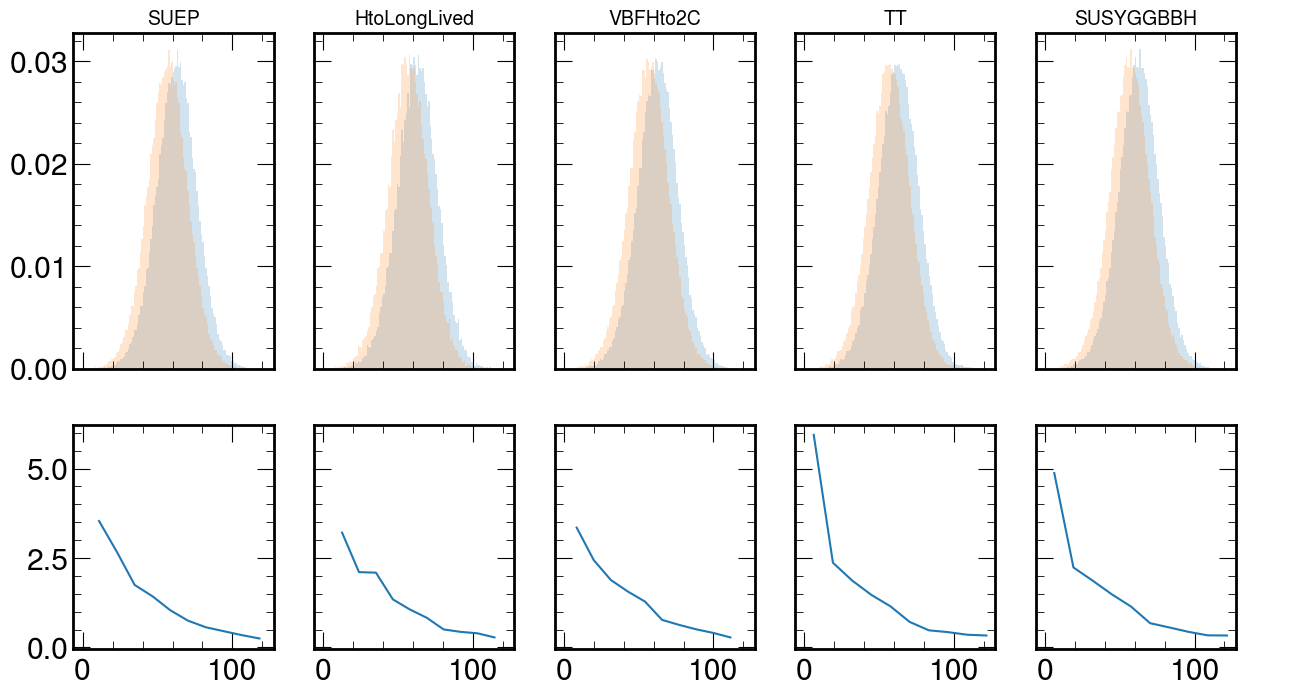

In [296]:
fig, axs = plt.subplots(2, 5, figsize=(15, 8), sharey='row', sharex=True, height_ratios=(0.6, 0.4))

bins = range(120)
for i, (proc, npv) in enumerate(nPV_signal.items()):
    axs[0][i].hist(npv, label=proc, bins=bins, alpha=0.2, density=True)
    target = npv - npv.mean() + 57
    axs[0][i].hist(target, label=proc, bins=bins, alpha=0.2, density=True)
    axs[0][i].set_title(proc, fontsize=14)
    source, bin_edges = np.histogram(npv, bins=10)
    target, _ = np.histogram(target, bins=bin_edges)
    ratios = target / source
    # axs[1][i].hist(npv/target, bins=bins)
    bin_centers = [bin_edges[i] + (bin_edges[i+1] - bin_edges[i])/2 for i in range(len(bin_edges)-1)]
    print(bin_centers)
    # print(ratios)
    # break
    axs[1][i].plot(bin_centers, ratios)

    # plt.legend()
# plt.tight_layout()
# plt.legend(loc="upper right", frameon=False)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
def make_reweighting_plot(npv_dict, bins):
    fig, axs = plt.subplots(2, len(nPV_signal), figsize=(20, 11), sharey='row', sharex=True, height_ratios=(0.6, 0.4))
    for i, (proc, npv) in enumerate(npv_dict.items()):
        # _, bins = np.histogram(npv, bins=bins)
        # print(f'bins = {bins}')
        target = npv - npv.mean() + 57

        print(f'target.mean() = {target.mean()}')
        
        source_h, _ = np.histogram(npv, bins=bins)
        target_h, _ = np.histogram(target, bins=bins)
        ratios = target_h / source_h
        
        bin_indices = np.digitize(npv, bins) - 1
        weights = ratios[bin_indices]
        bin_centers = [bins[i] + (bins[i+1] - bins[i])/2 for i in range(len(bins)-1)]

        print(f'NEW MEAN = {np.average(npv, weights=weights)}')


        # reweighted = npv * weights
        print(f'npv.shape = {npv.shape}')
        print(f'weights.shape = {weights.shape}')
        axs[0][i].hist(npv, label=proc, bins=range(135), alpha=0.2, density=True)
        axs[0][i].hist(target, label=proc, bins=range(135), alpha=0.2, density=True)
        axs[0][i].set_title(proc, fontsize=14)
        axs[0][i].hist(npv, label=proc, bins=range(135), alpha=0.2, density=True, weights=weights, histtype='step')
        axs[1][i].plot(bin_centers, ratios)
        axs[1][i].set_xlabel('nPV')        
    axs[0][0].set_ylabel('a.u.')
    axs[1][0].set_ylabel('Reweighting factor')
    plt.show()
    

# def make_reweighting_plot_linear(npv_dict, bins):
#     fig, axs = plt.subplots(2, len(nPV_signal), figsize=(20, 11), sharey='row', sharex=True, height_ratios=(0.6, 0.4))
#     for i, (proc, npv) in enumerate(npv_dict.items()):
#         axs[0][i].hist(npv, label=proc, bins=bins, alpha=0.2, density=True)
#         target = npv - npv.mean() + 57
#         axs[0][i].hist(target, label=proc, bins=bins, alpha=0.2, density=True)
#         axs[0][i].set_title(proc, fontsize=14)
#         source, _ = np.histogram(npv, bins=bins, density=True)
#         target, _ = np.histogram(target, bins=bins, density=True)
#         bin_centers = np.array([bins[i] + (bins[i+1] - bins[i])/2 for i in range(len(bins)-1)])
#         ratios = -0.02 * (bin_centers - 57) + 1
#         axs[0][i].plot(bin_centers, source*ratios)
#         axs[1][i].plot(bin_centers, ratios)
#         axs[1][i].set_xlabel('nPV')
#     axs[0][0].set_ylabel('a.u.')
#     axs[1][0].set_ylabel('Reweighting factor')
#     plt.show()

make_reweighting_plot(nPV_signal, bins=range(-20, 150))
# make_reweighting_plot(nPV_signal, bins=range(0, 135, 5))
# make_reweighting_plot(nPV_signal, bins=[
#     0, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90, 100, 120, 135
# ])
# make_reweighting_plot(nPV_signal, bins=range(0, 120, 4))
# make_reweighting_plot(nPV_signal, bins=10)
# make_reweighting_plot(nPV_signal, bins=[0, 20, 30, 120])

# make_reweighting_plot_linear(nPV_signal, bins=range(120))

In [118]:
import h5py
print(datasets)
for fn in datasets:
    npv = h5py.File(fn, "r")["nPV"][:].astype("float32")
    print(npv)
    

['/Users/linogerlach/Projects/Princeton/cicada/data/PU-factors/ZB_RunB.h5', '/Users/linogerlach/Projects/Princeton/cicada/data/PU-factors/ZB_RunC.h5', '/Users/linogerlach/Projects/Princeton/cicada/data/PU-factors/ZB_RunD.h5', '/Users/linogerlach/Projects/Princeton/cicada/data/PU-factors/EZB0_RunC.h5']
[8.4248326e+08 8.4248326e+08 8.4248326e+08 ... 1.7021260e+09 1.7021260e+09
 1.7021260e+09]
[8.0893658e+08 8.0893658e+08 8.0893658e+08 ... 1.0428867e+09 1.0428867e+09
 1.0428867e+09]
[8.3886112e+07 8.3886112e+07 8.3886112e+07 ... 1.1778918e+09 1.1778918e+09
 1.1778918e+09]
[1.8185797e+09 1.8185797e+09 1.8185797e+09 ... 9.5993094e+08 9.5993094e+08
 9.5993094e+08]


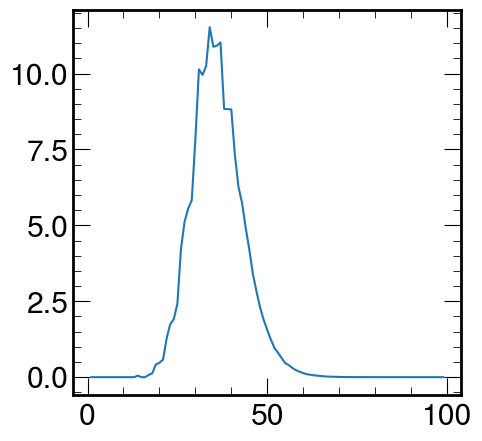

In [ ]:
with open('data/PU-factors/TT_PU_Factors.json', 'r') as f:
    pu_factors = json.load(f)

npvs, ws = [], []
for npv in range(1, 100):
    npvs.append(npv)
    ws.append(pu_factors[str(npv)])


plt.figure(figsize=(5,5))
plt.plot(npvs, ws)
plt.show()